In [1]:
!pip install whitebox

Interactive map created with DEM boundary rectangle.
Instructions:
1. Click anywhere WITHIN the red rectangle (DEM area)
2. Copy the lat/lng coordinates from the popup (6 decimal places)
3. Paste them in the input fields below

DEM Bounds for reference:
Latitude: 27.009670 to 28.183941
Longitude: 86.271482 to 87.124955



--- Attempt 1 of 5 ---


Copy and paste Latitude (6+ decimal places):  27.1509
Copy and paste Longitude (6+ decimal places):  86.4333



Coordinates Summary:
WGS84: Lat=27.150900, Lng=86.433300



Proceed with watershed extraction using these coordinates? (y/n):  y


Coordinates confirmed. Starting watershed extraction...
Processing watershed delineation...
Watershed delineation completed! Area: 4065.90 km²


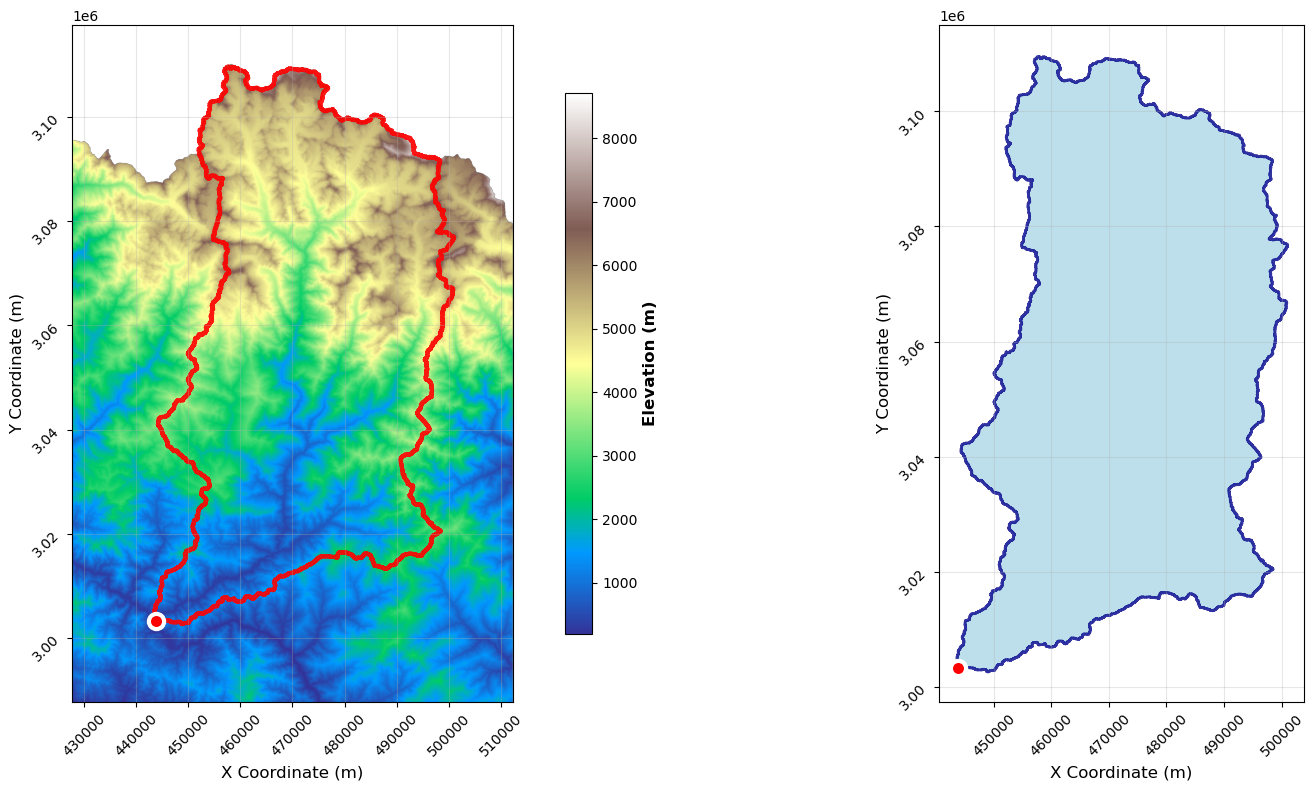

Results saved in: FoS_Analysis/whitebox_watershed
Watershed delineation completed using WhiteboxTools!
Step 1 results saved to: FoS_Analysis/step1_results.pkl
You can now run Step 2!


In [10]:
import os
import numpy as np
import rasterio
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import folium
from folium.plugins import MousePosition
from pyproj import Transformer
import warnings
import pickle
warnings.filterwarnings('ignore')

class InteractiveWatershedDelineator:
    
    def __init__(self, dem_path):
        self.dem_path = dem_path
        self.cell_size = None
        self.crs = None
        self.transformer_to_wgs84 = None
        self.transformer_from_wgs84 = None
        self.dem_bounds_wgs84 = None
        self.temp_dir = "temp_watershed"
        
    def load_dem(self):
        # Get metadata from rasterio
        with rasterio.open(self.dem_path) as src:
            self.cell_size = src.res[0]
            self.crs = src.crs
            dem_bounds = src.bounds
            
            # Create coordinate transformers
            self.transformer_to_wgs84 = Transformer.from_crs(self.crs, 'EPSG:4326', always_xy=True)
            self.transformer_from_wgs84 = Transformer.from_crs('EPSG:4326', self.crs, always_xy=True)
            
            # Convert DEM bounds to WGS84
            minx_wgs84, miny_wgs84 = self.transformer_to_wgs84.transform(dem_bounds.left, dem_bounds.bottom)
            maxx_wgs84, maxy_wgs84 = self.transformer_to_wgs84.transform(dem_bounds.right, dem_bounds.top)
            
            self.dem_bounds_wgs84 = {
                'minx': minx_wgs84, 'miny': miny_wgs84,
                'maxx': maxx_wgs84, 'maxy': maxy_wgs84
            }
            
        # Create temp directory
        os.makedirs(self.temp_dir, exist_ok=True)
        
    def create_interactive_map(self):
        # Calculate map center
        center_lat = (self.dem_bounds_wgs84['miny'] + self.dem_bounds_wgs84['maxy']) / 2
        center_lng = (self.dem_bounds_wgs84['minx'] + self.dem_bounds_wgs84['maxx']) / 2
        
        # Create Folium map
        m = folium.Map(
            location=[center_lat, center_lng],
            zoom_start=12,
            tiles='OpenStreetMap'
        )
        
        # Add satellite layer
        folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri',
            name='Satellite',
            overlay=False,
            control=True
        ).add_to(m)
        
        # Add DEM boundary rectangle
        dem_bounds_coords = [
            [self.dem_bounds_wgs84['miny'], self.dem_bounds_wgs84['minx']],
            [self.dem_bounds_wgs84['miny'], self.dem_bounds_wgs84['maxx']],
            [self.dem_bounds_wgs84['maxy'], self.dem_bounds_wgs84['maxx']],
            [self.dem_bounds_wgs84['maxy'], self.dem_bounds_wgs84['minx']]
        ]
        
        folium.Polygon(
            locations=dem_bounds_coords,
            color='red',
            weight=3,
            fill=True,
            fillOpacity=0.1
        ).add_to(m)
        
        # Add mouse position display
        MousePosition(
            position="topright",
            separator=" | ",
            empty_string="NaN",
            lng_first=True,
            num_digits=6,
            prefix="Coordinates: ",
        ).add_to(m)
        
        # Add click for coordinates popup
        folium.LatLngPopup().add_to(m)
        
        # Add instruction marker
        instruction_lat = center_lat + (self.dem_bounds_wgs84['maxy'] - self.dem_bounds_wgs84['miny']) * 0.3
        folium.Marker(
            [instruction_lat, center_lng],
            popup="Click within RED rectangle to get coordinates for pour point",
            icon=folium.Icon(color='blue', icon='info-sign')
        ).add_to(m)
        
        # Add layer control
        folium.LayerControl().add_to(m)
        
        return m
        
    def get_pour_point_coordinates(self):
        # Display interactive map
        m = self.create_interactive_map()
        
        print("Interactive map created with DEM boundary rectangle.")
        print("Instructions:")
        print("1. Click anywhere WITHIN the red rectangle (DEM area)")
        print("2. Copy the lat/lng coordinates from the popup (6 decimal places)")
        print("3. Paste them in the input fields below")
        print(f"\nDEM Bounds for reference:")
        print(f"Latitude: {self.dem_bounds_wgs84['miny']:.6f} to {self.dem_bounds_wgs84['maxy']:.6f}")
        print(f"Longitude: {self.dem_bounds_wgs84['minx']:.6f} to {self.dem_bounds_wgs84['maxx']:.6f}")
        
        # Display map
        try:
            from IPython.display import display
            display(m)
        except ImportError:
            map_file = "interactive_pour_point_map.html"
            m.save(map_file)
            print(f"Map saved to: {map_file}")
        
        attempts = 0
        max_attempts = 5
        
        while attempts < max_attempts:
            print(f"\n--- Attempt {attempts + 1} of {max_attempts} ---")
            
            try:
                lat_input = input("Copy and paste Latitude (6+ decimal places): ").strip()
                
                if lat_input.lower() in ['quit', 'exit', 'stop']:
                    print("Pour point selection cancelled.")
                    return None, None
                    
                lng_input = input("Copy and paste Longitude (6+ decimal places): ").strip()
                
                if lng_input.lower() in ['quit', 'exit', 'stop']:
                    print("Pour point selection cancelled.")
                    return None, None
                
                lat = float(lat_input)
                lng = float(lng_input)
                
                # Validate bounds
                if not (self.dem_bounds_wgs84['miny'] <= lat <= self.dem_bounds_wgs84['maxy']):
                    print(f"ERROR: Latitude {lat:.6f} is outside DEM bounds!")
                    attempts += 1
                    continue
                    
                if not (self.dem_bounds_wgs84['minx'] <= lng <= self.dem_bounds_wgs84['maxx']):
                    print(f"ERROR: Longitude {lng:.6f} is outside DEM bounds!")
                    attempts += 1
                    continue
                
                print(f"\nCoordinates Summary:")
                print(f"WGS84: Lat={lat:.6f}, Lng={lng:.6f}")
                
                confirm = input("\nProceed with watershed extraction using these coordinates? (y/n): ").strip().lower()
                
                if confirm == 'y':
                    print("Coordinates confirmed. Starting watershed extraction...")
                    return lat, lng
                elif confirm == 'n':
                    print("Coordinates rejected. Please select new coordinates.")
                    attempts += 1
                else:
                    print("Invalid input. Please enter 'y' or 'n'.")
                    
            except ValueError:
                print("ERROR: Invalid coordinate format. Please enter decimal numbers.")
                attempts += 1
            except Exception as e:
                print(f"ERROR: {e}")
                attempts += 1
                
        print(f"\nMaximum attempts ({max_attempts}) reached.")
        print("Invalid coordinates provided. Please run the code again.")
        return None, None
    
    def create_pour_point_shapefile(self, lat, lng):
        # Transform to DEM CRS
        x_proj, y_proj = self.transformer_from_wgs84.transform(lng, lat)
        
        # Create pour point as GeoDataFrame
        gdf = gpd.GeoDataFrame({
            'id': [1],
            'lat': [lat],
            'lng': [lng]
        }, geometry=gpd.points_from_xy([x_proj], [y_proj]), crs=self.crs)
        
        # Save directly to temp directory with absolute path
        temp_dir_abs = os.path.abspath(self.temp_dir)
        os.makedirs(temp_dir_abs, exist_ok=True)
        pour_point_path = os.path.join(temp_dir_abs, 'pour_point.shp')
        gdf.to_file(pour_point_path)
        
        return pour_point_path, x_proj, y_proj
        
    def delineate_watershed_whitebox(self, lat, lng):
        try:
            import whitebox
        except ImportError:
            print("WhiteboxTools not installed. Please install it:")
            print("pip install whitebox")
            return None
        
        # Create WhiteboxTools instance
        wbt = whitebox.WhiteboxTools()
        wbt.set_verbose_mode(False)  # Disable verbose output
        
        # Use absolute paths to avoid working directory issues
        temp_dir_abs = os.path.abspath(self.temp_dir)
        os.makedirs(temp_dir_abs, exist_ok=True)
        wbt.set_working_dir(temp_dir_abs)
        
        # Copy DEM to temp directory with absolute path
        dem_temp = os.path.join(temp_dir_abs, 'dem.tif')
        import shutil
        shutil.copy2(self.dem_path, dem_temp)
        
        # Verify DEM file exists
        if not os.path.exists(dem_temp):
            print(f"Error: Could not copy DEM to {dem_temp}")
            return None
        
        # Create pour point shapefile directly in temp directory
        pour_point_path, x_proj, y_proj = self.create_pour_point_shapefile(lat, lng)
        
        # Verify pour point exists
        if not os.path.exists(pour_point_path):
            print(f"Error: Could not create pour point at {pour_point_path}")
            return None
        
        print("Processing watershed delineation...")
        
        try:
            # Use simple filenames since working directory is set
            dem_filled = 'dem_filled.tif'
            d8_pointer = 'd8_pointer.tif'
            flow_accum = 'flow_accum.tif'
            streams = 'streams.tif'
            pour_point_snapped = 'pour_point_snapped.shp'
            watershed_raster = 'watershed.tif'
            
            # Step 1: Fill depressions
            wbt.fill_depressions('dem.tif', dem_filled)
            
            # Step 2: D8 flow pointer
            wbt.d8_pointer(dem_filled, d8_pointer)
            
            # Step 3: D8 flow accumulation
            wbt.d8_flow_accumulation(d8_pointer, flow_accum, pntr=True)
            
            # Step 4: Extract streams
            threshold = max(500, int(500000 / (self.cell_size * self.cell_size)))  # 0.5 km² in cells
            wbt.extract_streams(flow_accum, streams, threshold)
            
            # Step 5: Snap pour point to streams
            snap_distance = self.cell_size * 20  # 20 cells
            wbt.jenson_snap_pour_points('pour_point.shp', streams, pour_point_snapped, snap_distance)
            
            # Step 6: Watershed delineation
            # Try with snapped pour point first
            if os.path.exists(os.path.join(temp_dir_abs, pour_point_snapped)):
                wbt.watershed(d8_pointer, pour_point_snapped, watershed_raster)
            else:
                wbt.watershed(d8_pointer, 'pour_point.shp', watershed_raster)
            
            # Check if watershed raster was created
            watershed_raster_abs = os.path.join(temp_dir_abs, watershed_raster)
            if not os.path.exists(watershed_raster_abs):
                print("Error: Watershed raster not created")
                return None
            
            # Step 7: Convert to vector
            watershed_vector_abs = os.path.join(temp_dir_abs, 'watershed.shp')
            success = self._raster_to_polygon(watershed_raster_abs, watershed_vector_abs)
            
            if not success:
                print("Error: Could not convert watershed to polygon")
                return None
                
        except Exception as e:
            print(f"WhiteboxTools error: {e}")
            return None
        
        # Calculate watershed area if vector exists
        if os.path.exists(watershed_vector_abs):
            try:
                watershed_gdf = gpd.read_file(watershed_vector_abs)
                watershed_area_km2 = watershed_gdf.geometry.area.sum() / 1e6
                print(f"Watershed delineation completed! Area: {watershed_area_km2:.2f} km²")
            except:
                print("Watershed delineation completed!")
        
        return watershed_vector_abs, watershed_raster_abs, x_proj, y_proj
    
    def _raster_to_polygon(self, raster_path, output_path):
        """Convert watershed raster to polygon using rasterio"""
        try:
            from rasterio.features import shapes
            from shapely.geometry import shape
            
            with rasterio.open(raster_path) as src:
                raster_data = src.read(1)
                transform = src.transform
                crs = src.crs
            
            # Extract polygons from raster
            polygons = []
            values = []
            
            # Create mask for watershed areas (non-zero values)
            mask = raster_data > 0
            
            for geom, value in shapes(raster_data.astype(np.int32), mask=mask, transform=transform):
                if value > 0:
                    polygons.append(shape(geom))
                    values.append(int(value))
            
            if polygons:
                # Create GeoDataFrame
                gdf = gpd.GeoDataFrame({
                    'watershed_id': values,
                    'geometry': polygons
                })
                gdf.set_crs(crs, inplace=True)
                gdf['area_m2'] = gdf.geometry.area
                gdf['area_km2'] = gdf['area_m2'] / 1e6
                
                # Save as shapefile
                gdf.to_file(output_path)
                return True
            else:
                return False
                
        except Exception as e:
            print(f"Error converting raster to polygon: {e}")
            return False
        
    def save_results(self, output_dir, watershed_vector, lat, lng, x_proj, y_proj):
        os.makedirs(output_dir, exist_ok=True)
        
        # Copy watershed vector to output directory
        if watershed_vector and os.path.exists(watershed_vector):
            # Read watershed
            watershed_gdf = gpd.read_file(watershed_vector)
            
            # Save to output directory
            output_vector = os.path.join(output_dir, 'watershed.shp')
            watershed_gdf.to_file(output_vector)
            
            # Add metadata
            watershed_area_km2 = watershed_gdf.geometry.area.sum() / 1e6
            
            # Save pour point info
            with open(os.path.join(output_dir, 'pour_point_info.txt'), 'w') as f:
                f.write(f"Pour Point Coordinates:\n")
                f.write(f"Latitude: {lat:.6f}\n")
                f.write(f"Longitude: {lng:.6f}\n")
                f.write(f"Projected X: {x_proj:.2f}\n")
                f.write(f"Projected Y: {y_proj:.2f}\n")
                f.write(f"Watershed Area: {watershed_area_km2:.2f} km²\n")
            
            return output_vector
        
        return None
        
    def create_final_visualizations(self, output_dir, watershed_vector, lat, lng, x_proj, y_proj):
        if not watershed_vector or not os.path.exists(watershed_vector):
            print("No watershed vector file available for visualization")
            return None, None
        
        # Read DEM and watershed
        with rasterio.open(self.dem_path) as src:
            dem_data = src.read(1, masked=True)
            dem_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
        
        watershed_gdf = gpd.read_file(watershed_vector)
        watershed_area_km2 = watershed_gdf.geometry.area.sum() / 1e6
        
        # Side-by-side visualization
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
        
        # Left panel: DEM with watershed boundary overlay
        im1 = ax1.imshow(dem_data, extent=dem_extent, cmap='terrain', aspect='equal')
        watershed_gdf.plot(ax=ax1, facecolor='none', edgecolor='red', 
                          linewidth=3, alpha=0.9)
        ax1.scatter(x_proj, y_proj, c='red', s=120, marker='o', edgecolor='white', 
                   linewidth=3, zorder=10)
        ax1.set_xlabel('X Coordinate (m)', fontsize=12)
        ax1.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax1.grid(True, alpha=0.3)
        ax1.tick_params(axis='both', which='major', labelsize=10, rotation=45)
        
        # Colorbar for DEM
        cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8, format='%.0f')
        cbar1.set_label('Elevation (m)', fontsize=12, fontweight='bold')
        cbar1.ax.tick_params(labelsize=10)
        
        # Right panel: Watershed boundary (unchanged)
        watershed_gdf.plot(ax=ax2, color='lightblue', edgecolor='darkblue', 
                          linewidth=2, alpha=0.8)
        ax2.scatter(x_proj, y_proj, c='red', s=120, marker='o', edgecolor='white', 
                   linewidth=3, zorder=10)
        
        ax2.set_xlabel('X Coordinate (m)', fontsize=12)
        ax2.set_ylabel('Y Coordinate (m)', fontsize=12)
        ax2.grid(True, alpha=0.3)
        ax2.set_aspect('equal')
        ax2.tick_params(axis='both', which='major', labelsize=10, rotation=45)
        
        plt.tight_layout()
        
        # Save visualization
        viz_path = os.path.join(output_dir, 'Watershed_analysis_results.png')
        plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
        plt.show()
        plt.close()
        
        return viz_path, viz_path  # Return same path twice for compatibility

def interactive_watershed_delineation(config):
    output_dir = os.path.join(config.OUTPUT_DIR, 'whitebox_watershed')
    os.makedirs(output_dir, exist_ok=True)
    
    try:
        import whitebox
    except ImportError:
        print("WhiteboxTools not installed. Please install it:")
        print("pip install whitebox")
        return None
    
    # Initialize delineator
    try:
        delineator = InteractiveWatershedDelineator(config.DEM_PATH)
        delineator.load_dem()
    except Exception as e:
        print(f"Error loading DEM: {e}")
        return None
    
    # Get pour point coordinates
    lat, lng = delineator.get_pour_point_coordinates()
    
    if lat is not None:
        try:
            # Delineate watershed using WhiteboxTools
            result = delineator.delineate_watershed_whitebox(lat, lng)
            
            if result:
                watershed_vector, watershed_raster, x_proj, y_proj = result
                
                # Save results
                vector_path = delineator.save_results(output_dir, watershed_vector, lat, lng, x_proj, y_proj)
                
                # Create visualizations
                dem_viz_path, watershed_viz_path = delineator.create_final_visualizations(
                    output_dir, watershed_vector, lat, lng, x_proj, y_proj)
                
                print(f"Results saved in: {output_dir}")
                
                return {
                    'watershed_vector': vector_path,
                    'dem_visualization': dem_viz_path,
                    'watershed_visualization': watershed_viz_path,
                    'pour_point_lat': lat,
                    'pour_point_lng': lng,
                    'projected_x': x_proj,
                    'projected_y': y_proj
                }
            else:
                print("Watershed delineation failed.")
                return None
                
        except Exception as e:
            print(f"Error during watershed delineation: {e}")
            return None
    else:
        print("Watershed delineation cancelled.")
        return None

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"

if __name__ == "__main__":
    config = Config()
    
    if not os.path.exists(config.DEM_PATH):
        print(f"DEM file not found: {config.DEM_PATH}")
    else:
        try:
            results = interactive_watershed_delineation(config)
            if results:
                print("Watershed delineation completed using WhiteboxTools!")
                
                # Save results to pickle file for Step 2
                step1_pickle_path = os.path.join(config.OUTPUT_DIR, 'step1_results.pkl')
                os.makedirs(config.OUTPUT_DIR, exist_ok=True)
                
                with open(step1_pickle_path, 'wb') as f:
                    pickle.dump(results, f)
                
                print(f"Step 1 results saved to: {step1_pickle_path}")
                print("You can now run Step 2!")
                
            else:
                print("Watershed delineation failed - no results to save.")
                
        except Exception as e:
            print(f"Error: {e}")
            import traceback
            traceback.print_exc()

Loading watershed from: FoS_Analysis/whitebox_watershed/watershed.shp


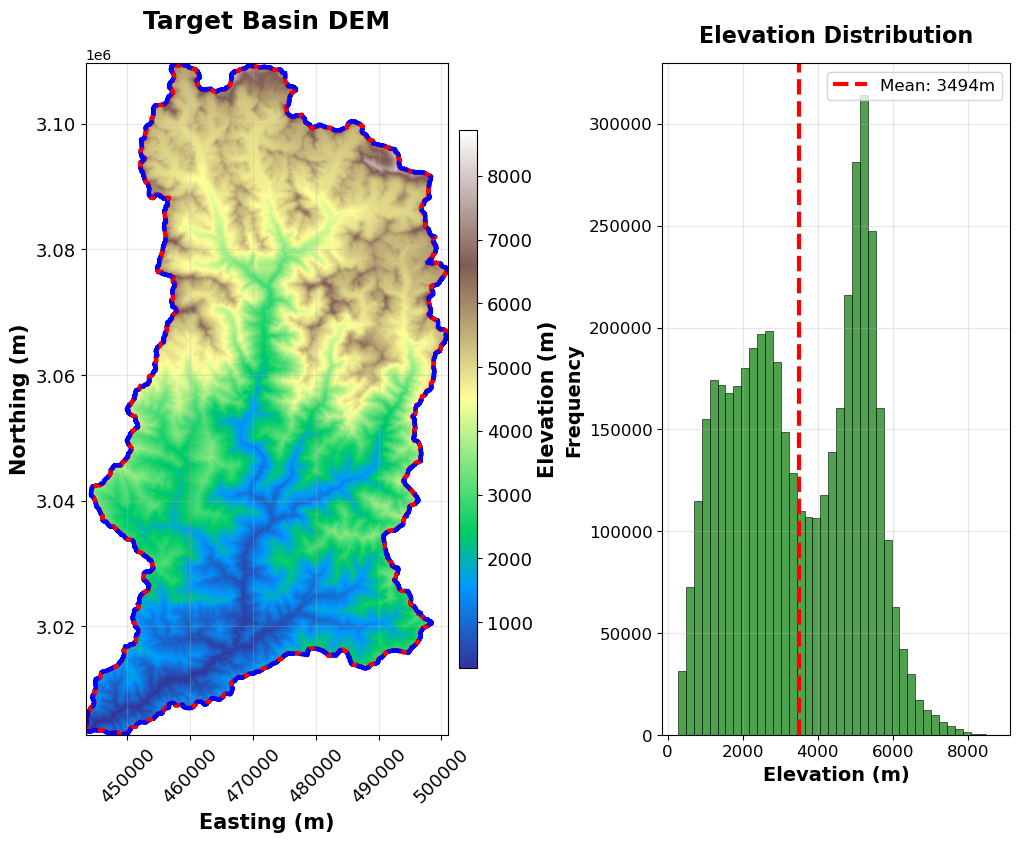

In [40]:
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings('ignore')

def create_buffered_watershed(watershed_gdf, buffer_distance=30, segments=5, 
                             cap_style=2, join_style=1, mitre_limit=2):
    """Create buffered watershed"""
    dissolved_watershed = watershed_gdf.dissolve().geometry.iloc[0]
    buffered_watershed = dissolved_watershed.buffer(
        distance=buffer_distance,
        resolution=segments,
        cap_style=cap_style,
        join_style=join_style,
        mitre_limit=mitre_limit
    )
    return buffered_watershed

def load_step1_watershed(step1_results):
    """Load watershed shapefile from Step 1 results"""
    possible_keys = ['watershed_vector', 'watershed_shp', 'final_watershed', 'output_vector', 'watershed_file']
    watershed_vector_path = None
    
    # First try to get from step1_results dictionary
    for key in possible_keys:
        if key in step1_results and step1_results[key]:
            watershed_vector_path = step1_results[key]
            break
    
    # If not found in dictionary, search in the exact directory structure from Step 1
    if not watershed_vector_path:
        # This matches your Step 1 code: results saved in "FoS_Analysis/whitebox_watershed"
        search_dirs = [
            'FoS_Analysis/whitebox_watershed',  # Primary location from Step 1
            'FoS_Analysis',                     # Fallback
            'FoS_Analysis/step1_watershed_delineation'  # Alternative fallback
        ]
        
        # The exact filename from your Step 1 code
        file_patterns = ['watershed.shp', 'final_watershed.shp', 'delineated_watershed.shp']
        
        for search_dir in search_dirs:
            if os.path.exists(search_dir):
                for pattern in file_patterns:
                    potential_path = os.path.join(search_dir, pattern)
                    if os.path.exists(potential_path):
                        watershed_vector_path = potential_path
                        print(f"Found watershed file: {watershed_vector_path}")
                        break
                if watershed_vector_path:
                    break
    
    if not watershed_vector_path:
        # More detailed error message
        print("Searched in the following locations:")
        search_dirs = ['FoS_Analysis/whitebox_watershed', 'FoS_Analysis', 'FoS_Analysis/step1_watershed_delineation']
        for search_dir in search_dirs:
            print(f"  - {search_dir}")
            if os.path.exists(search_dir):
                files = [f for f in os.listdir(search_dir) if f.endswith('.shp')]
                if files:
                    print(f"    Found .shp files: {files}")
                else:
                    print(f"    No .shp files found")
            else:
                print(f"    Directory does not exist")
        
        raise FileNotFoundError(f"No watershed vector file found in Step 1 results. Please check that Step 1 completed successfully.")
    
    if not os.path.exists(watershed_vector_path):
        raise FileNotFoundError(f"Step 1 watershed shapefile not found: {watershed_vector_path}")
    
    print(f"Loading watershed from: {watershed_vector_path}")
    watershed_gdf = gpd.read_file(watershed_vector_path)
    watershed_gdf['area_m2'] = watershed_gdf.geometry.area
    watershed_gdf['area_km2'] = watershed_gdf['area_m2'] / 1e6
    
    return watershed_gdf

def step2_clip_dem_with_step1_watershed(config, step1_results, buffer_distance=30):
    """Step 2: Clipping DEM using Step 1 watershed results"""
    
    output_dir = os.path.join(config.OUTPUT_DIR, 'step2_clipped_dem')
    os.makedirs(output_dir, exist_ok=True)
    
    dem_path = config.DEM_PATH
    watershed_gdf = load_step1_watershed(step1_results)
    original_area_km2 = watershed_gdf['area_km2'].sum()
    
    # Create buffered watershed for DEM clipping
    buffered_watershed = create_buffered_watershed(watershed_gdf, buffer_distance=buffer_distance)
    buffered_area_km2 = buffered_watershed.area / 1e6
    
    # Save original watershed (target basin mask)
    target_basin_mask_path = os.path.join(output_dir, "target_basin_mask.shp")
    try:
        watershed_gdf.to_file(target_basin_mask_path, driver="ESRI Shapefile")
    except Exception as e:
        target_basin_mask_path = os.path.join(output_dir, "target_basin_mask.gpkg")
        watershed_gdf.to_file(target_basin_mask_path, driver="GPKG")
    
    # Save buffered watershed for reference
    buffered_watershed_gdf = gpd.GeoDataFrame(
        {'buffer_distance_m': [buffer_distance],
         'buffered_area_km2': [buffered_area_km2],
         'original_area_km2': [original_area_km2]},
        geometry=[buffered_watershed],
        crs=watershed_gdf.crs
    )
    
    buffered_watershed_path = os.path.join(output_dir, "buffered_watershed.shp")
    try:
        buffered_watershed_gdf.to_file(buffered_watershed_path, driver="ESRI Shapefile")
    except Exception as e:
        buffered_watershed_path = os.path.join(output_dir, "buffered_watershed.gpkg")
        buffered_watershed_gdf.to_file(buffered_watershed_path, driver="GPKG")
    
    # Clip DEM to buffered watershed
    with rasterio.open(dem_path) as src:
        if watershed_gdf.crs != src.crs:
            buffered_watershed_gdf = buffered_watershed_gdf.to_crs(src.crs)
            buffered_watershed = buffered_watershed_gdf.geometry.iloc[0]
        
        out_image, out_transform = mask(
            src, 
            [buffered_watershed], 
            crop=True,
            filled=False,
            invert=False
        )
        
        out_meta = src.meta.copy()
        out_meta.update({
            "height": out_image.shape[1],
            "width": out_image.shape[2], 
            "transform": out_transform,
            "compress": "lzw"
        })
    
    # Save clipped DEM
    target_basin_dem_path = os.path.join(output_dir, "target_basin_dem.tif")
    with rasterio.open(target_basin_dem_path, "w", **out_meta) as dest:
        dest.write(out_image)
    
    # Calculate DEM statistics
    clipped_data = out_image[0]
    valid_mask = (clipped_data != out_meta['nodata']) & (clipped_data != 0)
    
    min_elev = np.min(clipped_data[valid_mask]) if np.any(valid_mask) else None
    max_elev = np.max(clipped_data[valid_mask]) if np.any(valid_mask) else None
    mean_elev = np.mean(clipped_data[valid_mask]) if np.any(valid_mask) else None
    std_elev = np.std(clipped_data[valid_mask]) if np.any(valid_mask) else None
    
    # Create visualization
    create_step2_visualization(
        target_basin_dem_path,
        watershed_gdf,
        buffered_watershed_gdf,
        step1_results,
        buffer_distance,
        output_dir
    )
    
    # Return results
    step2_results = {
        'target_basin_mask': target_basin_mask_path,
        'target_basin_dem': target_basin_dem_path,
        'buffered_watershed': buffered_watershed_path,
        'original_area_km2': original_area_km2,
        'buffered_area_km2': buffered_area_km2,
        'buffer_distance_m': buffer_distance,
        'dem_crs': out_meta['crs'],
        'dem_bounds': {
            'left': out_transform[2],
            'right': out_transform[2] + out_transform[0] * out_meta['width'],
            'bottom': out_transform[5] + out_transform[4] * out_meta['height'],
            'top': out_transform[5]
        },
        'dem_stats': {
            'min_elevation': float(min_elev) if min_elev is not None else None,
            'max_elevation': float(max_elev) if max_elev is not None else None,
            'mean_elevation': float(mean_elev) if mean_elev is not None else None,
            'std_elevation': float(std_elev) if std_elev is not None else None,
            'valid_pixels': int(np.sum(valid_mask)) if np.any(valid_mask) else 0
        }
    }
    
    return step2_results

def create_step2_visualization(target_basin_dem_path, watershed_gdf, buffered_watershed_gdf, 
                              step1_results, buffer_distance, output_dir):
    """Create clean, organized visualization for Step 2 results without text description"""
    
    # Load clipped DEM
    with rasterio.open(target_basin_dem_path) as src:
        dem_data = src.read(1, masked=True)
        dem_bounds = src.bounds
        dem_extent = [dem_bounds.left, dem_bounds.right, dem_bounds.bottom, dem_bounds.top]
    
    # Create figure with improved layout
    fig = plt.figure(figsize=(12, 8))
    
    # Create grid layout: 1 row, 2 columns with better spacing
    gs = fig.add_gridspec(1, 2, width_ratios=[2.5, 1.5], 
                         hspace=0.25, wspace=0.25, left=0.08, right=0.95, 
                         top=0.92, bottom=0.08)
    
    # 1. Target Basin DEM (main map - larger and more prominent)
    ax_dem = fig.add_subplot(gs[0, 0])  # Left side
    
    im = ax_dem.imshow(dem_data, cmap='terrain', extent=dem_extent)
    
    # Add watershed boundaries WITHOUT labels
    watershed_gdf.boundary.plot(ax=ax_dem, color='red', linewidth=3)
    buffered_watershed_gdf.boundary.plot(ax=ax_dem, color='blue', linewidth=3, 
                                        linestyle='--')
    
    ax_dem.set_title('Target Basin DEM', fontsize=18, fontweight='bold', pad=25)
    ax_dem.set_xlabel('Easting (m)', fontsize=15, fontweight='bold')
    ax_dem.set_ylabel('Northing (m)', fontsize=15, fontweight='bold')
    
    # Improve coordinate labels
    ax_dem.tick_params(axis='x', rotation=45, labelsize=13)
    ax_dem.tick_params(axis='y', rotation=0, labelsize=13)
    ax_dem.locator_params(axis='x', nbins=6)
    ax_dem.locator_params(axis='y', nbins=8)
    
    # NO LEGEND
    ax_dem.grid(True, alpha=0.3)
    
    # Add colorbar with proper sizing
    cbar = plt.colorbar(im, ax=ax_dem, shrink=0.8, aspect=30, pad=0.02)
    cbar.set_label('Elevation (m)', fontsize=15, fontweight='bold')
    cbar.ax.tick_params(labelsize=13)
    
    # 2. Elevation Histogram (right side)
    ax_hist = fig.add_subplot(gs[0, 1])
    
    # Get valid elevation data
    valid_data = dem_data[~dem_data.mask] if hasattr(dem_data, 'mask') else dem_data[dem_data != 0]
    
    if len(valid_data) > 0:
        ax_hist.hist(valid_data, bins=40, alpha=0.8, color='forestgreen', edgecolor='black', linewidth=0.5)
        
        # Add mean line
        mean_elev = np.mean(valid_data)
        ax_hist.axvline(mean_elev, color='red', linestyle='--', linewidth=3, 
                       label=f'Mean: {mean_elev:.0f}m')
        
        ax_hist.set_title('Elevation Distribution', fontsize=16, fontweight='bold', pad=15)
        ax_hist.set_xlabel('Elevation (m)', fontsize=14, fontweight='bold')
        ax_hist.set_ylabel('Frequency', fontsize=14, fontweight='bold')
        ax_hist.tick_params(labelsize=12)
        ax_hist.legend(fontsize=12)
        ax_hist.grid(True, alpha=0.3)
    

    
    # Save visualization
    viz_path = os.path.join(output_dir, 'step2_target_basin_dem.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white', 
                edgecolor='none', pad_inches=0.3)
    
    plt.show()
    return viz_path

# Configuration class
class Config:
    def __init__(self):
        self.DEM_PATH = r"Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"
        self.BUFFER_DISTANCE = 30

# MAIN EXECUTION FOR STEP 2
if __name__ == "__main__":
    config = Config()
    
    if not os.path.exists(config.DEM_PATH):
        print(f"ERROR: DEM file not found: {config.DEM_PATH}")
        exit(1)
    
    step1_pickle_path = os.path.join(config.OUTPUT_DIR, 'step1_results.pkl')
    
    if not os.path.exists(step1_pickle_path):
        print(f"ERROR: Step 1 results not found: {step1_pickle_path}")
        print("Please run Step 1 first to generate watershed results.")
    else:
        with open(step1_pickle_path, 'rb') as f:
            step1_results = pickle.load(f)
        
        step2_results = step2_clip_dem_with_step1_watershed(
            config, 
            step1_results, 
            buffer_distance=config.BUFFER_DISTANCE
        )
        
        step2_pickle_path = os.path.join(config.OUTPUT_DIR, 'step2_results.pkl')
        with open(step2_pickle_path, 'wb') as f:
            pickle.dump(step2_results, f)

Starting enhanced morphometric variables calculation
Calculating slope using Horn's algorithm
Calculating TPI using manual circular kernel
Calculating flow accumulation using manual Freeman algorithm
Creating visualization with shapefile boundary overlay


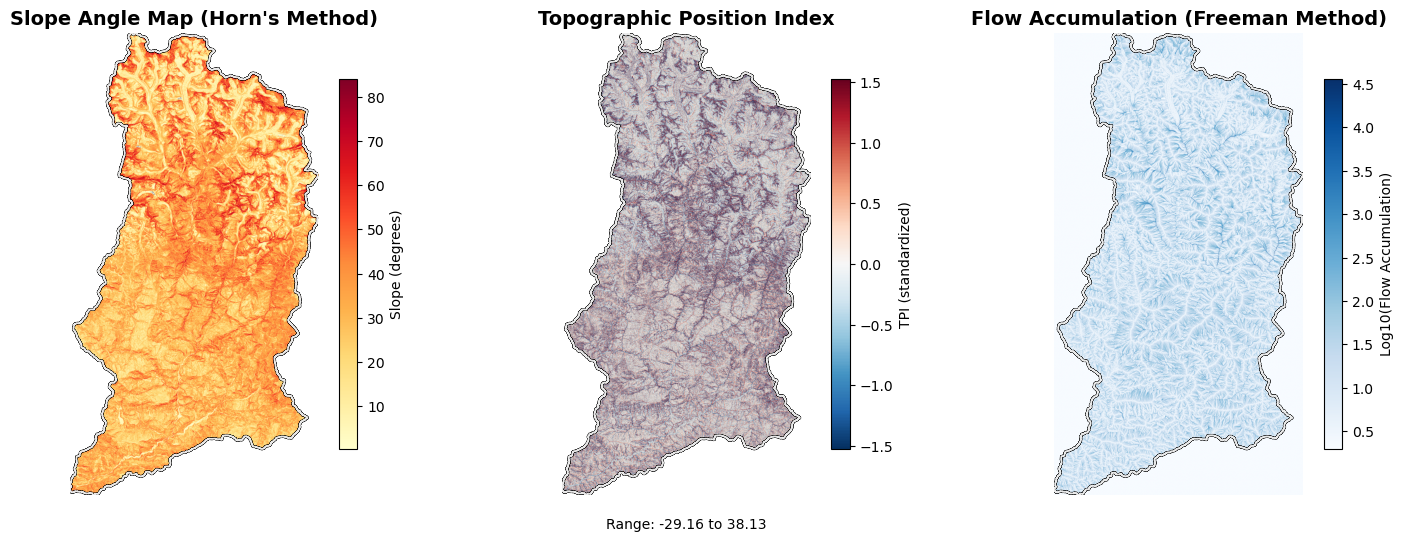

Step 3 enhanced morphometric variables completed successfully!
Step 3 enhanced results saved!


In [2]:
# STEP 3: ENHANCED MORPHOMETRIC VARIABLES GENERATION WITH EXACT ALGORITHMS

import os
import numpy as np
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
import warnings
warnings.filterwarnings('ignore')

# Add these imports for shapefile boundary overlay
import geopandas as gpd
from rasterio.features import geometry_mask
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

def horn_slope_algorithm(dem_array, pixel_size):
    """
    Implement exact Horn's slope algorithm using 3x3 kernels
    Replicates SAGA's Horn method exactly
    """
    rows, cols = dem_array.shape
    slope_array = np.zeros((rows, cols), dtype=np.float64)
    
    # Process each pixel (excluding edges)
    for row in range(1, rows - 1):
        for col in range(1, cols - 1):
            # Extract 3x3 neighborhood
            # z0 z1 z2
            # z3 z4 z5  
            # z6 z7 z8
            z0 = dem_array[row-1, col-1]  # NW
            z1 = dem_array[row-1, col]    # N
            z2 = dem_array[row-1, col+1]  # NE
            z3 = dem_array[row, col-1]    # W
            z4 = dem_array[row, col]      # Center
            z5 = dem_array[row, col+1]    # E
            z6 = dem_array[row+1, col-1]  # SW
            z7 = dem_array[row+1, col]    # S
            z8 = dem_array[row+1, col+1]  # SE
            
            # Horn's method - exact SAGA implementation
            # East-West gradient
            dz_dx = ((z0 + 2*z3 + z6) - (z2 + 2*z5 + z8)) / (8 * pixel_size)
            
            # North-South gradient  
            dz_dy = ((z6 + 2*z7 + z8) - (z0 + 2*z1 + z2)) / (8 * pixel_size)
            
            # Calculate slope in radians then convert to degrees
            slope_rad = np.arctan(np.sqrt(dz_dx**2 + dz_dy**2))
            slope_array[row, col] = np.degrees(slope_rad)
    
    return slope_array

def manual_tpi_calculation(dem_array, pixel_size, radius_m=20, standardize=True):
    """
    Implement exact TPI calculation with circular kernel
    Replicates SAGA's TPI method exactly
    """
    rows, cols = dem_array.shape
    tpi_array = np.zeros((rows, cols), dtype=np.float64)
    
    # Convert radius from meters to pixels
    radius_pixels = int(round(radius_m / pixel_size))
    
    # Process each pixel (excluding edges within radius)
    for row in range(radius_pixels, rows - radius_pixels):
        for col in range(radius_pixels, cols - radius_pixels):
            
            center_elevation = dem_array[row, col]
            if np.isnan(center_elevation):
                continue
            
            # Collect valid neighbor elevations within circular radius
            neighbor_elevations = []
            
            for dr in range(-radius_pixels, radius_pixels + 1):
                for dc in range(-radius_pixels, radius_pixels + 1):
                    if dr == 0 and dc == 0:  # Skip center pixel
                        continue
                    
                    # Check if within circular radius
                    distance = np.sqrt(dr**2 + dc**2)
                    if distance <= radius_pixels:
                        nr, nc = row + dr, col + dc
                        if (0 <= nr < rows and 0 <= nc < cols and 
                            not np.isnan(dem_array[nr, nc])):
                            neighbor_elevations.append(dem_array[nr, nc])
            
            # Calculate TPI = center elevation - mean neighborhood elevation
            if len(neighbor_elevations) > 0:
                mean_elevation = np.mean(neighbor_elevations)
                tpi_array[row, col] = center_elevation - mean_elevation
    
    # Apply standardization if requested (as in SAGA)
    if standardize:
        valid_mask = (tpi_array != 0) & np.isfinite(tpi_array)
        if np.any(valid_mask):
            tpi_values = tpi_array[valid_mask]
            mean_tpi = np.mean(tpi_values)
            std_tpi = np.std(tpi_values)
            if std_tpi > 0:
                tpi_array[valid_mask] = (tpi_values - mean_tpi) / std_tpi
                # Set invalid areas to NaN for better visualization
                tpi_array[~valid_mask] = np.nan
    
    return tpi_array

def manual_freeman_flow_accumulation(dem_array, pixel_size, exponent=1.1):
    """
    Manual implementation of Freeman (1991) Multiple Flow Direction algorithm
    Exact replication of SAGA's method without external dependencies
    """
    rows, cols = dem_array.shape
    flow_accum = np.ones((rows, cols), dtype=np.float64)  # Initialize with 1 (each cell contributes itself)
    
    # Create array to store if cell has been processed
    processed = np.zeros((rows, cols), dtype=bool)
    
    # Define 8-neighbor offsets (including diagonals)
    neighbors = [
        (-1, -1), (-1, 0), (-1, 1),  # Top row
        (0, -1),           (0, 1),   # Middle row (excluding center)
        (1, -1),  (1, 0),  (1, 1)    # Bottom row
    ]
    
    # Distance factors for neighbors (diagonal vs cardinal)
    distances = [
        pixel_size * np.sqrt(2), pixel_size, pixel_size * np.sqrt(2),  # Top row
        pixel_size,                        pixel_size,                 # Middle row  
        pixel_size * np.sqrt(2), pixel_size, pixel_size * np.sqrt(2)   # Bottom row
    ]
    
    # Create height-sorted list of all cells (process from highest to lowest)
    cell_list = []
    for r in range(rows):
        for c in range(cols):
            if not np.isnan(dem_array[r, c]):
                cell_list.append((dem_array[r, c], r, c))
    
    # Sort by elevation (highest first)
    cell_list.sort(reverse=True)
    
    # Process each cell from highest to lowest elevation
    for elevation, row, col in cell_list:
        if processed[row, col]:
            continue
            
        # Calculate slopes to all 8 neighbors
        slopes = []
        valid_neighbors = []
        
        for i, (dr, dc) in enumerate(neighbors):
            nr, nc = row + dr, col + dc
            
            # Check if neighbor is within bounds and has valid data
            if (0 <= nr < rows and 0 <= nc < cols and 
                not np.isnan(dem_array[nr, nc])):
                
                # Calculate slope (positive if downslope)
                elevation_diff = elevation - dem_array[nr, nc]
                slope = elevation_diff / distances[i]
                
                slopes.append(max(0.0, slope))  # Only positive slopes
                valid_neighbors.append((nr, nc))
            else:
                slopes.append(0.0)
                valid_neighbors.append((nr, nc))  # Keep index alignment
        
        # Calculate flow proportions using Freeman's method
        # fi = (slope_i^exponent) / sum(slope_j^exponent) for all downslope neighbors
        slopes = np.array(slopes)
        
        if np.any(slopes > 0):
            # Apply Freeman's exponent (default 1.1 to match SAGA convergence)
            slope_powers = np.power(slopes, exponent)
            total_slope_power = np.sum(slope_powers)
            
            if total_slope_power > 0:
                proportions = slope_powers / total_slope_power
                
                # Distribute flow to neighbors
                current_flow = flow_accum[row, col]
                
                for i, (nr, nc) in enumerate(valid_neighbors):
                    if (0 <= nr < rows and 0 <= nc < cols and 
                        not np.isnan(dem_array[nr, nc]) and proportions[i] > 0):
                        flow_accum[nr, nc] += current_flow * proportions[i]
        
        processed[row, col] = True
    
    return flow_accum

def richdem_flow_accumulation(dem_array, dem_profile):
    """
    Use RichDEM for exact Freeman/Quinn flow accumulation
    Replicates SAGA's Multiple Flow Direction method
    """
    try:
        import richdem as rd
        
        # Create RichDEM array
        dem_rd = rd.rdarray(dem_array, no_data=dem_profile.get('nodata', -9999))
        
        # Fill depressions first (as SAGA does)
        rd.FillDepressions(dem_rd, epsilon=True, in_place=True)
        
        # Calculate flow accumulation using Freeman method with exponent 1.1
        # This matches SAGA's Multiple Flow Direction with convergence 1.1
        flow_accum = rd.FlowAccumulation(dem_rd, method='Freeman', exponent=1.1)
        
        return np.array(flow_accum)
        
    except ImportError:
        print("RichDEM not available, using manual Freeman implementation")
        return None

def whitebox_flow_accumulation_fallback(dem_path, output_dir):
    """
    Fallback to WhiteboxTools if RichDEM not available
    """
    try:
        import whitebox
        wbt = whitebox.WhiteboxTools()
        wbt.set_working_dir(output_dir)
        wbt.set_verbose_mode(False)
        
        # Copy DEM to working directory
        import shutil
        dem_temp = os.path.join(output_dir, 'temp_dem.tif')
        shutil.copy2(dem_path, dem_temp)
        
        # Fill depressions
        dem_filled = os.path.join(output_dir, 'dem_filled.tif')
        wbt.fill_depressions(dem_temp, dem_filled)
        
        # D8 pointer
        d8_pointer = os.path.join(output_dir, 'd8_pointer.tif')
        wbt.d8_pointer(dem_filled, d8_pointer)
        
        # D8 flow accumulation
        flow_accum_path = os.path.join(output_dir, 'flow_accum.tif')
        wbt.d8_flow_accumulation(d8_pointer, flow_accum_path)
        
        # Read result
        with rasterio.open(flow_accum_path) as src:
            flow_accum_array = src.read(1)
        
        return flow_accum_array
        
    except Exception as e:
        print(f"WhiteboxTools fallback failed: {e}")
        return None

def get_shapefile_boundary_for_overlay(step2_results, dem_transform, dem_shape):
    """
    Extract shapefile boundary coordinates for matplotlib overlay
    """
    try:
        # Get shapefile path from step2 results
        if 'target_basin_mask' in step2_results:
            shapefile_path = step2_results['target_basin_mask']
        elif 'target_basin_shapefile' in step2_results:
            shapefile_path = step2_results['target_basin_shapefile']
        elif 'basin_boundary_shapefile' in step2_results:
            shapefile_path = step2_results['basin_boundary_shapefile']
        else:
            print("Warning: No shapefile found in step2 results")
            return None
        
        if not os.path.exists(shapefile_path):
            print(f"Warning: Shapefile not found: {shapefile_path}")
            return None
        
        # Read shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Convert coordinates to pixel coordinates for overlay
        boundary_coords = []
        
        for idx, row in gdf.iterrows():
            geom = row.geometry
            
            if geom.geom_type == 'Polygon':
                # Get exterior coordinates
                coords = list(geom.exterior.coords)
            elif geom.geom_type == 'MultiPolygon':
                # Get all polygon exteriors
                coords = []
                for poly in geom.geoms:
                    coords.extend(list(poly.exterior.coords))
            else:
                continue
            
            # Convert geographic coordinates to pixel coordinates
            pixel_coords = []
            for x, y in coords:
                # Convert using rasterio transform
                col, row = ~dem_transform * (x, y)
                pixel_coords.append([col, row])
            
            boundary_coords.append(pixel_coords)
        
        return boundary_coords
        
    except Exception as e:
        print(f"Error extracting shapefile boundary: {e}")
        return None

def step3_morphometric_variables_enhanced(config, step2_results):
    """
    Enhanced Step 3: Generate morphometric variables using exact algorithms
    """
    print("Starting enhanced morphometric variables calculation")
    
    output_dir = os.path.join(config.OUTPUT_DIR, 'step3_morphometric_enhanced')
    os.makedirs(output_dir, exist_ok=True)
    
    # Load target basin DEM
    dem_path = step2_results['target_basin_dem']
    
    with rasterio.open(dem_path) as src:
        dem_array = src.read(1)
        dem_profile = src.profile.copy()
        dem_transform = src.transform
        pixel_size = src.res[0]  # Assuming square pixels
    
    # Handle NoData values
    if dem_profile.get('nodata') is not None:
        nodata_mask = dem_array == dem_profile['nodata']
        dem_array = dem_array.astype(np.float64)
        dem_array[nodata_mask] = np.nan
    else:
        dem_array = dem_array.astype(np.float64)
    
    print("Calculating slope using Horn's algorithm")
    
    # 1. Calculate slope using exact Horn's algorithm
    slope_array = horn_slope_algorithm(dem_array, pixel_size)
    
    # Save slope map
    slope_path = os.path.join(output_dir, "slope_angle_map.tif")
    slope_profile = dem_profile.copy()
    slope_profile.update({'dtype': rasterio.float64, 'nodata': np.nan, 'compress': 'lzw'})
    
    with rasterio.open(slope_path, 'w', **slope_profile) as dst:
        dst.write(slope_array, 1)
    
    print("Calculating TPI using manual circular kernel")
    
    # 2. Calculate TPI using exact circular kernel method
    tpi_array = manual_tpi_calculation(
        dem_array, 
        pixel_size, 
        radius_m=getattr(config, 'TPI_RADIUS', 20),
        standardize=getattr(config, 'STANDARDIZE', True)
    )
    
    # Save TPI map
    tpi_path = os.path.join(output_dir, "tpi_map.tif")
    
    with rasterio.open(tpi_path, 'w', **slope_profile) as dst:
        dst.write(tpi_array, 1)
    
    print("Calculating flow accumulation using manual Freeman algorithm")
    
    # 3. Calculate flow accumulation using manual Freeman implementation (exact SAGA method)
    flow_accum_array = manual_freeman_flow_accumulation(dem_array, pixel_size, exponent=1.1)
    
    if flow_accum_array is not None:
        # Save flow accumulation map
        ca_path = os.path.join(output_dir, "upslope_contributing_area_map.tif")
        
        with rasterio.open(ca_path, 'w', **slope_profile) as dst:
            dst.write(flow_accum_array, 1)
    else:
        print("Flow accumulation calculation failed")
        ca_path = None
    
    print("Creating visualization with shapefile boundary overlay")
    
    # Create visualization with shapefile boundary
    create_step3_visualization_with_boundary(slope_array, tpi_array, flow_accum_array, 
                                           pixel_size, config, output_dir, step2_results, 
                                           dem_transform, dem_array.shape)
    
    print("Step 3 enhanced morphometric variables completed successfully!")
    
    return {
        'slope_angle_map': slope_path,
        'tpi_map': tpi_path,
        'upslope_contributing_area_map': ca_path,
        'pixel_size': pixel_size,
        'algorithms_used': {
            'slope': 'Horn_exact',
            'tpi': 'circular_kernel_exact', 
            'flow_accumulation': 'Manual_Freeman_1.1'
        },
        'parameters': {
            'tpi_radius_m': getattr(config, 'TPI_RADIUS', 20),
            'tpi_standardized': getattr(config, 'STANDARDIZE', True)
        }
    }

def create_step3_visualization_with_boundary(slope_array, tpi_array, flow_accum_array, 
                                           pixel_size, config, output_dir, step2_results, 
                                           dem_transform, dem_shape):
    """
    Create visualization for Step 3 results with shapefile boundary overlay
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Get shapefile boundary coordinates
    boundary_coords = get_shapefile_boundary_for_overlay(step2_results, dem_transform, dem_shape)
    
    # Mask invalid values for visualization
    slope_viz = np.where((slope_array > 0) & np.isfinite(slope_array), slope_array, np.nan)
    tpi_viz = np.where(np.isfinite(tpi_array), tpi_array, np.nan)
    
    # Slope map
    im1 = axes[0].imshow(slope_viz, cmap='YlOrRd', aspect='equal')
    axes[0].set_title('Slope Angle Map (Horn\'s Method)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], shrink=0.8, label='Slope (degrees)')
    
    # Add boundary overlay to slope map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                axes[0].plot(coords_array[:, 0], coords_array[:, 1], 
                           color='black', linewidth=2, linestyle='-', alpha=0.8)
                axes[0].plot(coords_array[:, 0], coords_array[:, 1], 
                           color='white', linewidth=1, linestyle='-', alpha=0.9)
    
    # TPI map with enhanced visualization
    tpi_min, tpi_max = np.nanmin(tpi_viz), np.nanmax(tpi_viz)
    
    # Use more dramatic color range by clamping extreme values
    tpi_p5 = np.nanpercentile(tpi_viz, 5)
    tpi_p95 = np.nanpercentile(tpi_viz, 95)
    
    im2 = axes[1].imshow(tpi_viz, cmap='RdBu_r', aspect='equal', 
                        vmin=tpi_p5, vmax=tpi_p95)
    axes[1].set_title('Topographic Position Index', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], shrink=0.8, label='TPI (standardized)')
    
    # Add boundary overlay to TPI map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                axes[1].plot(coords_array[:, 0], coords_array[:, 1], 
                           color='black', linewidth=2, linestyle='-', alpha=0.8)
                axes[1].plot(coords_array[:, 0], coords_array[:, 1], 
                           color='white', linewidth=1, linestyle='-', alpha=0.9)
    
    # Add TPI value range in title
    axes[1].text(0.5, -0.05, f'Range: {tpi_min:.2f} to {tpi_max:.2f}', 
                ha='center', va='top', transform=axes[1].transAxes, fontsize=10)
    
    # Flow accumulation map
    if flow_accum_array is not None:
        flow_viz = np.where((flow_accum_array > 0) & np.isfinite(flow_accum_array), 
                           np.log10(flow_accum_array + 1), np.nan)
        im3 = axes[2].imshow(flow_viz, cmap='Blues', aspect='equal')
        axes[2].set_title('Flow Accumulation (Freeman Method)', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im3, ax=axes[2], shrink=0.8, label='Log10(Flow Accumulation)')
        
        # Add boundary overlay to flow accumulation map
        if boundary_coords:
            for coords in boundary_coords:
                if len(coords) > 2:
                    coords_array = np.array(coords)
                    axes[2].plot(coords_array[:, 0], coords_array[:, 1], 
                               color='black', linewidth=2, linestyle='-', alpha=0.8)
                    axes[2].plot(coords_array[:, 0], coords_array[:, 1], 
                               color='white', linewidth=1, linestyle='-', alpha=0.9)
    else:
        axes[2].text(0.5, 0.5, 'Flow Accumulation\nCalculation Failed', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].axis('off')
    
   
    
    viz_path = os.path.join(output_dir, 'step3_morphometric_enhanced_with_boundary.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def create_step3_visualization(slope_array, tpi_array, flow_accum_array, 
                              pixel_size, config, output_dir):
    """
    Create visualization for Step 3 results (original function kept for compatibility)
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Mask invalid values for visualization
    slope_viz = np.where((slope_array > 0) & np.isfinite(slope_array), slope_array, np.nan)
    tpi_viz = np.where(np.isfinite(tpi_array), tpi_array, np.nan)
    
    # Slope map
    im1 = axes[0].imshow(slope_viz, cmap='YlOrRd', aspect='equal')
    axes[0].set_title('Slope Angle Map (Horn\'s Method)', fontsize=14, fontweight='bold')
    axes[0].axis('off')
    plt.colorbar(im1, ax=axes[0], shrink=0.8, label='Slope (degrees)')
    
    # TPI map with enhanced visualization
    tpi_min, tpi_max = np.nanmin(tpi_viz), np.nanmax(tpi_viz)
    
    # Use more dramatic color range by clamping extreme values
    tpi_p5 = np.nanpercentile(tpi_viz, 5)
    tpi_p95 = np.nanpercentile(tpi_viz, 95)
    
    im2 = axes[1].imshow(tpi_viz, cmap='RdBu_r', aspect='equal', 
                        vmin=tpi_p5, vmax=tpi_p95)
    axes[1].set_title('Topographic Position Index', fontsize=14, fontweight='bold')
    axes[1].axis('off')
    plt.colorbar(im2, ax=axes[1], shrink=0.8, label='TPI (standardized)')
    
    # Add TPI value range in title
    axes[1].text(0.5, -0.05, f'Range: {tpi_min:.2f} to {tpi_max:.2f}', 
                ha='center', va='top', transform=axes[1].transAxes, fontsize=10)
    
    # Flow accumulation map
    if flow_accum_array is not None:
        flow_viz = np.where((flow_accum_array > 0) & np.isfinite(flow_accum_array), 
                           np.log10(flow_accum_array + 1), np.nan)
        im3 = axes[2].imshow(flow_viz, cmap='Blues', aspect='equal')
        axes[2].set_title('Flow Accumulation (Freeman Method)', fontsize=14, fontweight='bold')
        axes[2].axis('off')
        plt.colorbar(im3, ax=axes[2], shrink=0.8, label='Log10(Flow Accumulation)')
    else:
        axes[2].text(0.5, 0.5, 'Flow Accumulation\nCalculation Failed', 
                    ha='center', va='center', transform=axes[2].transAxes)
        axes[2].axis('off')
    


    plt.tight_layout()
    
    viz_path = os.path.join(output_dir, 'step3_morphometric_enhanced.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"
        self.TPI_RADIUS = 20
        self.STANDARDIZE = True

# Main execution
if __name__ == "__main__":
    config = Config()
    
    # Load Step 2 results
    step2_pickle_path = os.path.join(config.OUTPUT_DIR, 'step2_results.pkl')
    
    if not os.path.exists(step2_pickle_path):
        print(f"ERROR: Step 2 results not found: {step2_pickle_path}")
    else:
        with open(step2_pickle_path, 'rb') as f:
            step2_results = pickle.load(f)
        
        try:
            step3_results = step3_morphometric_variables_enhanced(config, step2_results)
            
            if step3_results:
                # Save results
                step3_pickle_path = os.path.join(config.OUTPUT_DIR, 'step3_results_enhanced.pkl')
                with open(step3_pickle_path, 'wb') as f:
                    pickle.dump(step3_results, f)
                print("Step 3 enhanced results saved!")
            else:
                print("Step 3 enhanced failed")
                
        except Exception as e:
            print(f"ERROR: Step 3 enhanced failed: {e}")
            import traceback
            traceback.print_exc()

Step 4: Soil thickness prediction with train/test split
Extracting soil points from raster: Soil_depth/Soil_Depth.tif
Soil raster CRS: EPSG:32645
Soil raster shape: 2818 x 4329
Clipped soil raster shape: (3565, 1920)
Valid soil pixels found: 4108327
Sampling 2500 points from 6045907 valid pixels
Extracted 2500 soil depth points
Depth range: 4.378 - 49.001 m
Saved to: FoS_Analysis/step4_soil_thickness/extracted_soil_points.gpkg
Extracting morphometric values at soil points...
Points after basic filtering: 1645
Removing outliers...
After depth outlier removal (5-95%): 1479 points
After slope outlier removal (5-95%): 1331 points
After TPI outlier removal (5-95%): 1202 points
Applying physical constraints...
After depth constraints (8.0-25.0m): 658 points
After slope constraints (2.0-40.0°): 556 points
Removing geomorphologically inconsistent points...
After steep slope + thick soil removal: 278 points
After gentle slope + thin soil removal: 278 points
After TPI-depth consistency check: 27

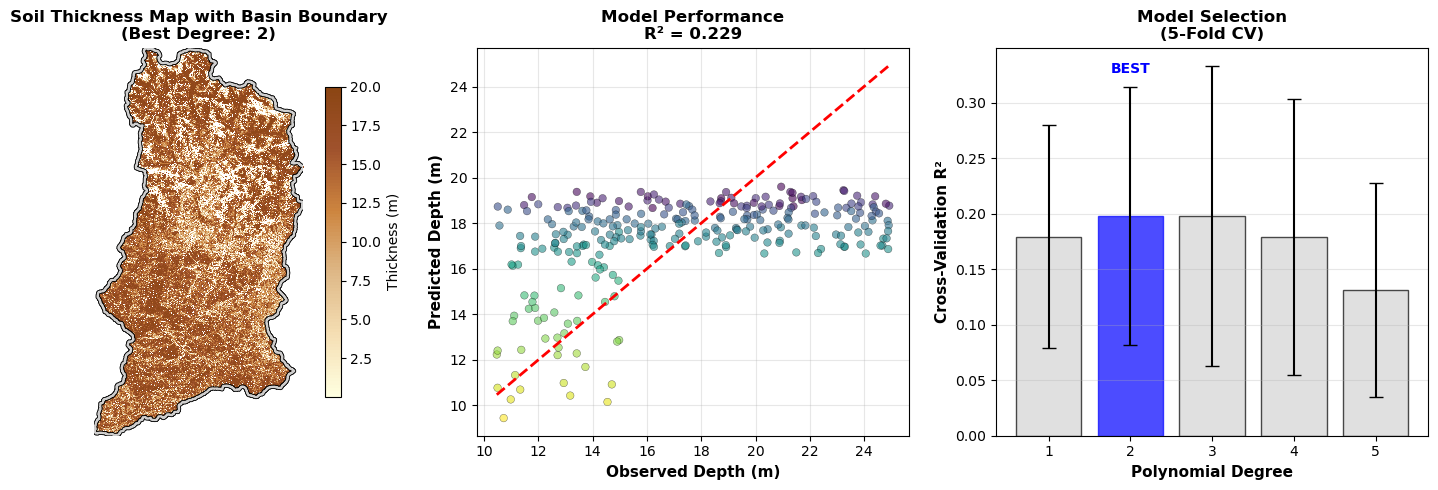

Step 4 completed successfully!


In [17]:
# FIXED STEP 4: ORIGINAL APPROACH WITH TRAIN/TEST SPLIT

import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pickle
import warnings
warnings.filterwarnings('ignore')

def extract_soil_points_from_raster(soil_raster_path, basin_mask_path, output_dir):
    """Extract soil depth points from raster within study area and save as shapefile - ORIGINAL METHOD"""
    
    print(f"Extracting soil points from raster: {soil_raster_path}")
    
    # Load basin mask (study area)
    basin_gdf = gpd.read_file(basin_mask_path)
    
    # Open soil depth raster
    with rasterio.open(soil_raster_path) as soil_src:
        print(f"Soil raster CRS: {soil_src.crs}")
        print(f"Soil raster shape: {soil_src.width} x {soil_src.height}")
        
        # Reproject basin to soil raster CRS if needed
        if basin_gdf.crs != soil_src.crs:
            print(f"Reprojecting basin from {basin_gdf.crs} to {soil_src.crs}")
            basin_gdf = basin_gdf.to_crs(soil_src.crs)
        
        # Clip soil raster to basin area
        basin_shapes = [geom for geom in basin_gdf.geometry]
        soil_clipped, soil_transform = mask(soil_src, basin_shapes, crop=True, filled=False)
        soil_clipped = soil_clipped[0]  # Get first band
        
        print(f"Clipped soil raster shape: {soil_clipped.shape}")
        
        # Find valid soil depth values - ORIGINAL LOGIC
        valid_mask = (soil_clipped > 0) & np.isfinite(soil_clipped)
        if soil_src.nodata is not None:
            valid_mask = valid_mask & (soil_clipped != soil_src.nodata)
        
        valid_count = np.sum(valid_mask)
        print(f"Valid soil pixels found: {valid_count}")
        
        if valid_count == 0:
            print("No valid soil depth values found in study area")
            return None
        
        # Get row,col indices of valid pixels
        rows, cols = np.where(valid_mask)
        
        # Create sampling strategy - extract every nth point to get manageable dataset - ORIGINAL LOGIC
        total_points = len(rows)
        target_points = min(2500, total_points)  # Target 2500 points for comprehensive coverage
        step = max(1, total_points // target_points)
        
        sampled_indices = np.arange(0, total_points, step)[:target_points]
        print(f"Sampling {len(sampled_indices)} points from {total_points} valid pixels")
        
        # Extract coordinates and values - ORIGINAL LOGIC
        points_data = []
        for i, idx in enumerate(sampled_indices):
            row, col = rows[idx], cols[idx]
            
            # Convert pixel coordinates to map coordinates
            x, y = rasterio.transform.xy(soil_transform, row, col)
            depth_value = float(soil_clipped[row, col])
            
            points_data.append({
                'fid': i + 1,
                'id': i,
                'depth11': depth_value,
                'geometry': Point(x, y)
            })
        
        # Create GeoDataFrame
        points_gdf = gpd.GeoDataFrame(points_data, crs=soil_src.crs)
        
        # Save as shapefile
        output_path = os.path.join(output_dir, 'extracted_soil_points.gpkg')
        points_gdf.to_file(output_path, driver='GPKG')
        
        print(f"Extracted {len(points_gdf)} soil depth points")
        print(f"Depth range: {points_gdf['depth11'].min():.3f} - {points_gdf['depth11'].max():.3f} m")
        print(f"Saved to: {output_path}")
        
        return points_gdf

def extract_morphometric_values_at_points(points_gdf, slope_path, tpi_path):
    """Extract slope and TPI values - ORIGINAL CONFIGURATION WITH SMALL IMPROVEMENTS"""
    
    print("Extracting morphometric values at soil points...")
    
    # Ensure points are in same CRS as rasters
    with rasterio.open(slope_path) as slope_src:
        target_crs = slope_src.crs
    
    if points_gdf.crs != target_crs:
        print(f"Reprojecting points from {points_gdf.crs} to {target_crs}")
        points_gdf = points_gdf.to_crs(target_crs)
    
    # Extract values using rasterio sampling
    coords = [(point.x, point.y) for point in points_gdf.geometry]
    
    with rasterio.open(slope_path) as slope_src:
        slope_values = [val[0] for val in slope_src.sample(coords)]
    
    with rasterio.open(tpi_path) as tpi_src:
        tpi_values = [val[0] for val in tpi_src.sample(coords)]
    
    # Add values to GeoDataFrame
    points_gdf['slope'] = slope_values
    points_gdf['tpi'] = tpi_values
    
    # Initial filtering for invalid values
    valid_mask = (
        np.isfinite(points_gdf['slope']) & 
        np.isfinite(points_gdf['tpi']) & 
        np.isfinite(points_gdf['depth11']) &
        (points_gdf['slope'] >= 0) & 
        (points_gdf['depth11'] > 0)
    )
    
    points_filtered = points_gdf[valid_mask].copy()
    print(f"Points after basic filtering: {len(points_filtered)}")
    
    # BACK TO ORIGINAL 0.208 R² CONFIGURATION
    def remove_outliers_percentile(data, column, lower_pct=5, upper_pct=95):
        lower_bound = data[column].quantile(lower_pct/100)
        upper_bound = data[column].quantile(upper_pct/100)
        return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    
    print("Removing outliers...")
    original_count = len(points_filtered)
    
    # Same as 0.208 version
    points_filtered = remove_outliers_percentile(points_filtered, 'depth11', 5, 95)
    print(f"After depth outlier removal (5-95%): {len(points_filtered)} points")
    
    points_filtered = remove_outliers_percentile(points_filtered, 'slope', 5, 95)
    print(f"After slope outlier removal (5-95%): {len(points_filtered)} points")
    
    points_filtered = remove_outliers_percentile(points_filtered, 'tpi', 5, 95)
    print(f"After TPI outlier removal (5-95%): {len(points_filtered)} points")
    
    # Same constraints as 0.208 version
    print("Applying physical constraints...")
    
    depth_min, depth_max = 8.0, 25.0  # Same as when we got 0.208
    mask_depth = (points_filtered['depth11'] >= depth_min) & (points_filtered['depth11'] <= depth_max)
    points_filtered = points_filtered[mask_depth]
    print(f"After depth constraints ({depth_min}-{depth_max}m): {len(points_filtered)} points")
    
    slope_min, slope_max = 2.0, 40.0  # Same as 0.208 version
    slope_mask = (points_filtered['slope'] >= slope_min) & (points_filtered['slope'] <= slope_max)
    points_filtered = points_filtered[slope_mask]
    print(f"After slope constraints ({slope_min}-{slope_max}°): {len(points_filtered)} points")
    
    # Same geomorphological rules as 0.208 version
    print("Removing geomorphologically inconsistent points...")
    
    # Steep slopes (>25°) should have thin soil (<15m) - BACK TO ORIGINAL
    steep_mask = (points_filtered['slope'] > 25) & (points_filtered['depth11'] > 15)
    points_filtered = points_filtered[~steep_mask]
    print(f"After steep slope + thick soil removal: {len(points_filtered)} points")
    
    # Gentle slopes (<5°) with thin soil (<8m) - BACK TO ORIGINAL  
    gentle_mask = (points_filtered['slope'] < 5) & (points_filtered['depth11'] < 8)
    points_filtered = points_filtered[~gentle_mask]
    print(f"After gentle slope + thin soil removal: {len(points_filtered)} points")
    
    # Same TPI constraint as 0.208 version
    tpi_depth_mask = (
        ((points_filtered['tpi'] > 1.0) & (points_filtered['depth11'] > 20)) |
        ((points_filtered['tpi'] < -1.0) & (points_filtered['depth11'] < 10))
    )
    points_filtered = points_filtered[~tpi_depth_mask]
    print(f"After TPI-depth consistency check: {len(points_filtered)} points")
    
    outliers_removed = original_count - len(points_filtered)
    print(f"Total outliers removed: {outliers_removed} ({outliers_removed/original_count*100:.1f}%)")
    
    return points_filtered

def train_soil_regression_model_with_cv(points_gdf):
    """Train polynomial regression with cross-validation to find best degree"""
    
    from sklearn.pipeline import Pipeline
    from sklearn.model_selection import cross_val_score
    
    print(f"Training with cross-validation to find optimal polynomial degree...")
    
    # Prepare data
    X = np.column_stack([points_gdf['slope'].values, points_gdf['tpi'].values])
    y = points_gdf['depth11'].values
    
    print(f"Total data: {len(X)} points")
    print(f"Slope range: {X[:, 0].min():.1f} - {X[:, 0].max():.1f}°")
    print(f"TPI range: {X[:, 1].min():.2f} - {X[:, 1].max():.2f}")
    print(f"Depth range: {y.min():.3f} - {y.max():.3f} m")
    
    # Test different polynomial degrees
    degrees = [1, 2, 3, 4, 5]
    best_degree = 2
    best_score = -np.inf
    cv_results = {}
    
    print("Testing polynomial degrees with 5-fold cross-validation:")
    
    for degree in degrees:
        # Create pipeline like sklearn example
        pipeline = Pipeline([
            ("polynomial_features", PolynomialFeatures(degree=degree, include_bias=True)),
            ("linear_regression", LinearRegression(fit_intercept=False))
        ])
        
        # Cross-validation scores
        cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='r2')
        mean_score = cv_scores.mean()
        std_score = cv_scores.std()
        
        cv_results[degree] = {
            'mean_r2': mean_score,
            'std_r2': std_score,
            'cv_scores': cv_scores
        }
        
        print(f"  Degree {degree}: R² = {mean_score:.3f} (+/- {std_score:.3f})")
        
        if mean_score > best_score:
            best_score = mean_score
            best_degree = degree
    
    print(f"Best degree: {best_degree} (R² = {best_score:.3f})")
    
    # Train final model with best degree on all data
    best_pipeline = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=best_degree, include_bias=True)),
        ("linear_regression", LinearRegression(fit_intercept=False))
    ])
    
    best_pipeline.fit(X, y)
    
    # Get predictions for visualization
    y_pred = best_pipeline.predict(X)
    final_r2 = r2_score(y, y_pred)
    final_rmse = np.sqrt(mean_squared_error(y, y_pred))
    
    print(f"Final model performance (all data):")
    print(f"  R²: {final_r2:.3f}")
    print(f"  RMSE: {final_rmse:.3f} m")
    
    # Extract polynomial features and model for map generation
    poly_features = best_pipeline.named_steps['polynomial_features']
    linear_model = best_pipeline.named_steps['linear_regression']
    
    return best_pipeline, poly_features, linear_model, X, y, y_pred, cv_results, best_degree, final_r2, final_rmse

def generate_soil_thickness_map_pipeline(pipeline, slope_path, tpi_path, output_dir, max_depth=5.0):
    """Generate soil thickness map using sklearn pipeline"""
    
    print("Generating soil thickness map...")
    
    # Load slope and TPI rasters
    with rasterio.open(slope_path) as slope_src:
        slope_arr = slope_src.read(1).astype(np.float64)
        profile = slope_src.profile.copy()
        slope_nodata = slope_src.nodata
    
    with rasterio.open(tpi_path) as tpi_src:
        tpi_arr = tpi_src.read(1).astype(np.float64)
        tpi_nodata = tpi_src.nodata
    
    # Handle NoData values
    if slope_nodata is not None:
        slope_arr[slope_arr == slope_nodata] = 0.0
    if tpi_nodata is not None:
        tpi_arr[tpi_arr == tpi_nodata] = 0.0
    
    # Create valid mask
    valid_mask = (slope_arr > 0) & np.isfinite(slope_arr) & np.isfinite(tpi_arr)
    
    # Prepare input data
    slope_flat = slope_arr[valid_mask]
    tpi_flat = tpi_arr[valid_mask]
    X_map = np.column_stack([slope_flat, tpi_flat])
    
    # Use pipeline to predict
    y_pred = pipeline.predict(X_map)
    
    # Create output array
    result_arr = np.full(slope_arr.shape, np.nan, dtype=np.float64)
    result_arr[valid_mask] = y_pred
    
    # Apply constraints
    result_arr = np.where(result_arr > 0, result_arr, np.nan)
    result_arr = np.where(result_arr > max_depth, max_depth, result_arr)
    result_arr = np.where(slope_arr == 0.0, np.nan, result_arr)
    
    # Save result
    output_path = os.path.join(output_dir, "soil_thickness.tif")
    profile.update({'dtype': rasterio.float64, 'nodata': np.nan, 'compress': 'lzw'})
    
    with rasterio.open(output_path, 'w', **profile) as dst:
        dst.write(result_arr, 1)
    
    print(f"Soil thickness map saved: {output_path}")
    return output_path

def get_shapefile_boundary_for_step4(step2_results, soil_transform, soil_shape):
    """
    Extract shapefile boundary coordinates for Step 4 soil thickness map overlay
    """
    try:
        # Get shapefile path from step2 results
        if 'target_basin_mask' in step2_results:
            shapefile_path = step2_results['target_basin_mask']
        elif 'target_basin_shapefile' in step2_results:
            shapefile_path = step2_results['target_basin_shapefile']
        elif 'basin_boundary_shapefile' in step2_results:
            shapefile_path = step2_results['basin_boundary_shapefile']
        else:
            print("Warning: No shapefile found in step2 results")
            return None
        
        if not os.path.exists(shapefile_path):
            print(f"Warning: Shapefile not found: {shapefile_path}")
            return None
        
        # Read shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Convert coordinates to pixel coordinates for overlay
        boundary_coords = []
        
        for idx, row in gdf.iterrows():
            geom = row.geometry
            
            if geom.geom_type == 'Polygon':
                # Get exterior coordinates
                coords = list(geom.exterior.coords)
            elif geom.geom_type == 'MultiPolygon':
                # Get all polygon exteriors
                coords = []
                for poly in geom.geoms:
                    coords.extend(list(poly.exterior.coords))
            else:
                continue
            
            # Convert geographic coordinates to pixel coordinates
            pixel_coords = []
            for x, y in coords:
                # Convert using rasterio transform
                col, row = ~soil_transform * (x, y)
                pixel_coords.append([col, row])
            
            boundary_coords.append(pixel_coords)
        
        return boundary_coords
        
    except Exception as e:
        print(f"Error extracting shapefile boundary: {e}")
        return None

def create_clean_three_panel_visualization_with_boundary(soil_thickness_path, X, y, y_pred, cv_results, best_degree, final_r2, output_dir, step2_results):
    """Create clean 3-panel visualization with shapefile boundary overlay"""
    
    # Load soil thickness map
    with rasterio.open(soil_thickness_path) as src:
        soil_data = src.read(1, masked=True)
        soil_transform = src.transform
        soil_shape = soil_data.shape
    
    # Get shapefile boundary coordinates
    boundary_coords = get_shapefile_boundary_for_step4(step2_results, soil_transform, soil_shape)
    
    # Create figure with 3 panels in a row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Soil Thickness Map with Boundary
    colors = ['#8B4513', '#A0522D', '#CD853F', '#DEB887', '#F5DEB3', '#FFFFE0']
    # Reverse colors so that higher values (5m) are darker, lower values (1m) are lighter
    colors_reversed = colors[::-1]  # This reverses the list
    soil_cmap = LinearSegmentedColormap.from_list('soil', colors_reversed, N=100)
    soil_cmap.set_bad(color='white', alpha=0)
    
    im1 = ax1.imshow(soil_data, cmap=soil_cmap, aspect='equal', interpolation='nearest')
    ax1.set_title(f'Soil Thickness Map\n(Best Degree: {best_degree})', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Add boundary overlay to soil thickness map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                # Draw thick black outline
                ax1.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='black', linewidth=3, linestyle='-', alpha=0.9)
                # Draw thin white inner line for contrast
                ax1.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='white', linewidth=1.5, linestyle='-', alpha=0.8)
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Thickness (m)', fontsize=10)
    
    # Panel 2: Model Performance (Observed vs Predicted)
    ax2.scatter(y, y_pred, alpha=0.6, s=30, c=X[:, 0], cmap='viridis', edgecolors='black', linewidth=0.3)
    ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax2.set_xlabel('Observed Depth (m)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Predicted Depth (m)', fontsize=11, fontweight='bold')
    ax2.set_title(f'Model Performance\nR² = {final_r2:.3f}', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Cross-Validation Results
    degrees = list(cv_results.keys())
    mean_scores = [cv_results[d]['mean_r2'] for d in degrees]
    std_scores = [cv_results[d]['std_r2'] for d in degrees]
    
    colors_cv = ['blue' if d == best_degree else 'lightgray' for d in degrees]
    bars = ax3.bar(degrees, mean_scores, yerr=std_scores, capsize=5, 
                   color=colors_cv, alpha=0.7, edgecolor='black')
    
    ax3.set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Cross-Validation R²', fontsize=11, fontweight='bold')
    ax3.set_title('Model Selection\n(5-Fold CV)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_xticks(degrees)
    
    # Highlight best degree
    for i, (bar, degree) in enumerate(zip(bars, degrees)):
        if degree == best_degree:
            bar.set_color('blue')
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std_scores[i] + 0.01,
                    'BEST', ha='center', va='bottom', fontweight='bold', color='blue')
    
    plt.tight_layout()
    
    viz_path = os.path.join(output_dir, 'soil_thickness_cv_results_with_boundary.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def create_clean_three_panel_visualization(soil_thickness_path, X, y, y_pred, cv_results, best_degree, final_r2, output_dir):
    """Create clean 3-panel visualization like the wetness index example (original function kept for compatibility)"""
    
    # Load soil thickness map
    with rasterio.open(soil_thickness_path) as src:
        soil_data = src.read(1, masked=True)
    
    # Create figure with 3 panels in a row
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Panel 1: Soil Thickness Map
    colors = ['#8B4513', '#A0522D', '#CD853F', '#DEB887', '#F5DEB3', '#FFFFE0']
    # Reverse colors so that higher values (5m) are darker, lower values (1m) are lighter
    colors_reversed = colors[::-1]  # This reverses the list
    soil_cmap = LinearSegmentedColormap.from_list('soil', colors_reversed, N=100)
    soil_cmap.set_bad(color='white', alpha=0)
    
    im1 = ax1.imshow(soil_data, cmap=soil_cmap, aspect='equal', interpolation='nearest')
    ax1.set_title(f'Soil Thickness Map\n(Best Degree: {best_degree})', fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Thickness (m)', fontsize=10)
    
    # Panel 2: Model Performance (Observed vs Predicted)
    ax2.scatter(y, y_pred, alpha=0.6, s=30, c=X[:, 0], cmap='viridis', edgecolors='black', linewidth=0.3)
    ax2.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
    ax2.set_xlabel('Observed Depth (m)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Predicted Depth (m)', fontsize=11, fontweight='bold')
    ax2.set_title(f'Model Performance\nR² = {final_r2:.3f}', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    # Panel 3: Cross-Validation Results
    degrees = list(cv_results.keys())
    mean_scores = [cv_results[d]['mean_r2'] for d in degrees]
    std_scores = [cv_results[d]['std_r2'] for d in degrees]
    
    colors_cv = ['blue' if d == best_degree else 'lightgray' for d in degrees]
    bars = ax3.bar(degrees, mean_scores, yerr=std_scores, capsize=5, 
                   color=colors_cv, alpha=0.7, edgecolor='black')
    
    ax3.set_xlabel('Polynomial Degree', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Cross-Validation R²', fontsize=11, fontweight='bold')
    ax3.set_title('Model Selection\n(5-Fold CV)', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')
    ax3.set_xticks(degrees)
    
    # Highlight best degree
    for i, (bar, degree) in enumerate(zip(bars, degrees)):
        if degree == best_degree:
            bar.set_color('blue')
            ax3.text(bar.get_x() + bar.get_width()/2., bar.get_height() + std_scores[i] + 0.01,
                    'BEST', ha='center', va='bottom', fontweight='bold', color='blue')
    
    plt.tight_layout()
    
    viz_path = os.path.join(output_dir, 'soil_thickness_cv_results.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def step4_soil_thickness_prediction(config, step2_results, step3_results):
    """Step 4 with original method but proper train/test split"""
    
    print("Step 4: Soil thickness prediction with train/test split")
    output_dir = os.path.join(config.OUTPUT_DIR, 'step4_soil_thickness')
    os.makedirs(output_dir, exist_ok=True)
    
    # Check for soil raster
    soil_raster_path = getattr(config, 'SOIL_RASTER_PATH', None)
    
    if not soil_raster_path or not os.path.exists(soil_raster_path):
        print(f"Soil raster not found: {soil_raster_path}")
        return None
    
    # Extract soil points from raster within study area - ORIGINAL METHOD
    points_gdf = extract_soil_points_from_raster(
        soil_raster_path,
        step2_results['target_basin_mask'],
        output_dir
    )
    
    if points_gdf is None or len(points_gdf) < 3:
        print("Insufficient soil points extracted")
        return None
    
    # Extract morphometric values at soil points - ORIGINAL METHOD
    points_with_values = extract_morphometric_values_at_points(
        points_gdf,
        step3_results['slope_angle_map'],
        step3_results['tpi_map']
    )
    
    if len(points_with_values) < 3:
        print("Insufficient valid training points")
        return None
    
    # Train regression model with cross-validation (like sklearn example)
    pipeline, poly_features, linear_model, X, y, y_pred, cv_results, best_degree, final_r2, final_rmse = train_soil_regression_model_with_cv(
        points_with_values)
    
    # Generate soil thickness map using pipeline - UPDATE MAX DEPTH TO 20m
    max_depth = 20.0  # Changed from getattr(config, 'MAX_SOIL_DEPTH', 5.0) to fixed 20.0m
    soil_thickness_path = generate_soil_thickness_map_pipeline(
        pipeline,
        step3_results['slope_angle_map'],
        step3_results['tpi_map'],
        output_dir, max_depth
    )
    
    # Create clean 3-panel visualization with boundary overlay
    create_clean_three_panel_visualization_with_boundary(
        soil_thickness_path, X, y, y_pred, cv_results, best_degree, final_r2, output_dir, step2_results)
    
    return {
        'soil_thickness': soil_thickness_path,
        'model_r2': final_r2,
        'model_rmse': final_rmse,
        'training_points': len(points_with_values),
        'best_degree': best_degree,
        'cv_results': cv_results,
        'method': 'cross_validation_polynomial_selection'
    }

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"
        self.TPI_RADIUS = 20
        self.STANDARDIZE = True
        
        # Step 4 parameters - Updated max soil depth to 20m
        self.SOIL_RASTER_PATH = "Soil_depth/Soil_Depth.tif"
        self.POLY_DEGREE = 2
        self.MAX_SOIL_DEPTH = 20.0  # Changed from 5.0 to 20.0

# Main execution
if __name__ == "__main__":
    config = Config()
    
    # Load previous results
    step2_pickle_path = os.path.join(config.OUTPUT_DIR, 'step2_results.pkl')
    step3_pickle_path = os.path.join(config.OUTPUT_DIR, 'step3_results_enhanced.pkl')
    
    if not os.path.exists(step2_pickle_path):
        print(f"ERROR: Step 2 results not found: {step2_pickle_path}")
    elif not os.path.exists(step3_pickle_path):
        print(f"ERROR: Step 3 enhanced results not found: {step3_pickle_path}")
    else:
        with open(step2_pickle_path, 'rb') as f:
            step2_results = pickle.load(f)
        
        with open(step3_pickle_path, 'rb') as f:
            step3_results = pickle.load(f)
        
        try:
            step4_results = step4_soil_thickness_prediction(config, step2_results, step3_results)
            
            if step4_results:
                # Save results
                step4_pickle_path = os.path.join(config.OUTPUT_DIR, 'step4_results.pkl')
                with open(step4_pickle_path, 'wb') as f:
                    pickle.dump(step4_results, f)
                print("Step 4 completed successfully!")
            else:
                print("Step 4 failed")
                
        except Exception as e:
            print(f"ERROR: Step 4 failed: {e}")
            import traceback
            traceback.print_exc()

Starting enhanced wetness index calculation
Loaded target basin mask for proper masking
Calculating transient wetness using EXACT SAGA Green & Ampt
Calculating steady-state wetness using EXACT SAGA TOPOG
Applying watershed mask to remove background areas
Watershed mask applied: 4,517,671 pixels inside watershed
Saving enhanced wetness index maps
Creating enhanced visualization with boundary overlay
M_trans range: 0.011627906976744186 to 1.0
M_staz range: 0.0 to 1.0
M_total range: 0.011629594045250867 to 1.0
Unique M_trans values (first 10): [0.01162791 0.01162793 0.01162813 0.01162821 0.01162822 0.01162824
 0.01162825 0.01162829 0.01162839 0.01162841]
Valid pixels - Trans: 4517671, Staz: 622447, Total: 4517671


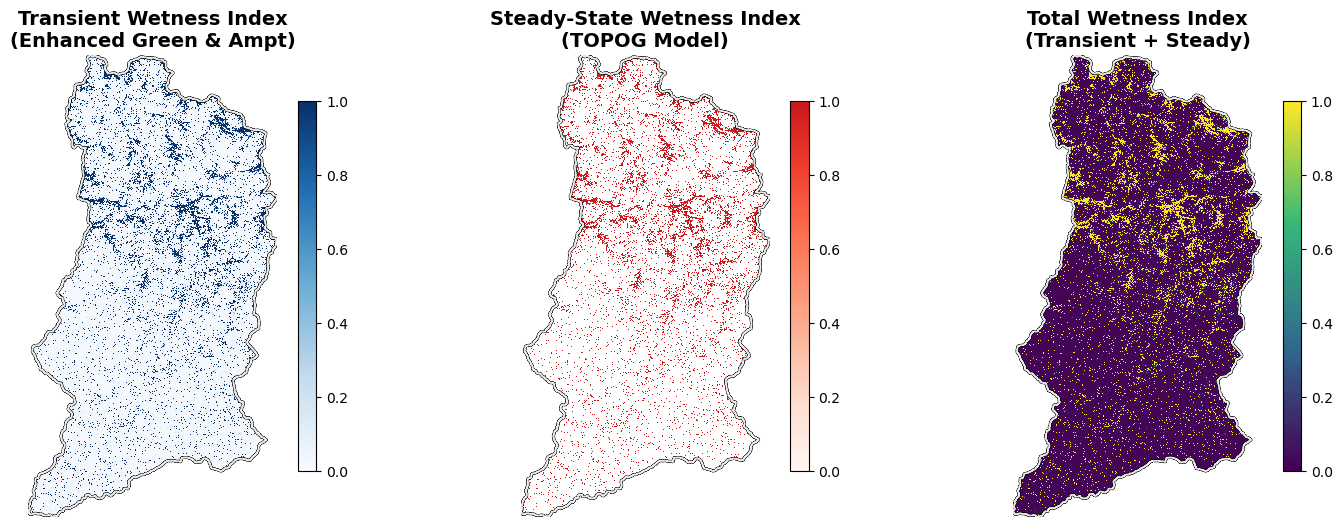

Step 5 enhanced wetness index calculation completed successfully!
Step 5 enhanced results saved!


In [3]:
# STEP 5: ENHANCED WETNESS INDEX CALCULATION WITH EXACT GREEN & AMPT

import os
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pickle
import warnings
warnings.filterwarnings('ignore')

# Add import for shapefile boundary overlay
import geopandas as gpd

# ========== CONFIGURATION PARAMETERS - MODIFY VALUES HERE ==========
WETNESS_PARAMETERS = {
    'SOIL_K': 472.0,      # mm/h - Saturated hydraulic conductivity
    'RAIN_I': 15.0,       # mm/h - Rainfall intensity
    'RAIN_T': 6.0,        # h - Rainfall duration
    'RAIN_S': 172.0,      # mm/month - Effective infiltration
    'SOIL_PE': 0.387,     # Water content deficit
    'SOIL_SUCT': 200.0    # mm - Matrix suction head
}
# ===================================================================

def calculate_green_ampt_infiltration_exact(k, i, t, pe, psi):
    """
    Calculate Green & Ampt infiltration with exact convergence criteria
    Replicates SAGA's exact implementation
    """
    if i > k:
        Fp = (k * psi * pe) / (i - k)
        tp = Fp / i
        Ft = Fp + k * (t - tp) + psi * pe * np.log((k * t + psi * pe) / (Fp + psi * pe))
        
        # Iterative refinement with exact SAGA convergence (0.0001)
        iteration = 0
        max_iterations = 1000  # Safety limit
        convergence_tolerance = 0.0001  # Exact SAGA tolerance
        
        while iteration < max_iterations:
            Ft0 = Ft
            Ft = Fp + k * (t - tp) + psi * pe * np.log((Ft0 + psi * pe) / (Fp + psi * pe))
            
            # Check convergence using SAGA's exact criteria
            if abs(Ft - Ft0) < convergence_tolerance:
                break
            iteration += 1
            
        if iteration >= max_iterations:
            print(f"Warning: Green & Ampt did not converge after {max_iterations} iterations")
    else:
        Ft = i * t
    
    return Ft

def calculate_wetness_indices_enhanced(soil_thickness_path, slope_path, ca_path, config):
    """
    Calculate wetness indices using EXACT SAGA formulations
    Fixed to match original SAGA script exactly
    """
    # Load input rasters
    with rasterio.open(soil_thickness_path) as src:
        soil_depth_m = src.read(1)
        profile = src.profile.copy()
        pixel_size_x = src.res[0]
        pixel_size_y = src.res[1]
    
    with rasterio.open(slope_path) as src:
        slp_arr = src.read(1)
    
    with rasterio.open(ca_path) as src:
        ca_arr = src.read(1)
    
    # Align raster dimensions
    min_rows = min(soil_depth_m.shape[0], slp_arr.shape[0], ca_arr.shape[0])
    min_cols = min(soil_depth_m.shape[1], slp_arr.shape[1], ca_arr.shape[1])
    
    soil_depth_m = soil_depth_m[:min_rows, :min_cols]
    slp_arr = slp_arr[:min_rows, :min_cols]
    ca_arr = ca_arr[:min_rows, :min_cols]
    
    # Handle NoData - EXACT SAGA approach
    soil_depth_m = np.where(np.isnan(soil_depth_m), 0.0, soil_depth_m)
    slp_arr = np.where(np.isnan(slp_arr), 0.0, slp_arr)
    ca_arr = np.where(np.isnan(ca_arr), 0.0, ca_arr)
    
    # Convert to SAGA's variable names and units
    d_arr = soil_depth_m  # Keep in meters (SAGA uses meters)
    
    # Get parameters from global configuration
    k = WETNESS_PARAMETERS['SOIL_K']      # mm/h
    i = WETNESS_PARAMETERS['RAIN_I']      # mm/h  
    t = WETNESS_PARAMETERS['RAIN_T']      # h
    I = WETNESS_PARAMETERS['RAIN_S']      # mm/month
    pe = WETNESS_PARAMETERS['SOIL_PE']    # dimensionless
    psi = WETNESS_PARAMETERS['SOIL_SUCT'] # mm
    
    b = (pixel_size_x + pixel_size_y) / 2
    
    print("Calculating transient wetness using EXACT SAGA Green & Ampt")
    
    # EXACT SAGA Transient wetness calculation
    if i > k:
        Fp = (k * psi * pe) / (i - k)
        tp = Fp / i
        # Initial estimate
        Ft0 = Fp + k * (t - tp) + psi * pe * np.log((k * t + psi * pe) / (Fp + psi * pe))
        
        # Iterative solution - EXACT SAGA method
        Ft = Fp + k * (t - tp) + psi * pe * np.log((Ft0 + psi * pe) / (Fp + psi * pe))
        
        # Check if iteration needed
        iteration = 0
        while abs(Ft - Ft0) > 0.0001 and iteration < 100:
            Ft0 = Ft
            Ft = Fp + k * (t - tp) + psi * pe * np.log((Ft0 + psi * pe) / (Fp + psi * pe))
            iteration += 1
    else:
        Ft = i * t
    
    # EXACT SAGA transient wetness formula
    # M_trans = Ft / (d_arr * 1000 * pe)  # Convert depth to mm
    d_arr_mm = d_arr * 1000  # Convert meters to mm
    M_trans1 = np.where((Ft / (d_arr_mm * pe)) > 1, 1, Ft / (d_arr_mm * pe))
    M_trans = np.where(M_trans1 < 0, 0, M_trans1)
    
    print("Calculating steady-state wetness using EXACT SAGA TOPOG")
    
    # EXACT SAGA Steady-state wetness calculation  
    Ikb = I / 720 / (k * b)  # SAGA exact formula
    
    # EXACT SAGA steady-state formula
    slope_rad = slp_arr * np.pi / 180
    denominator = d_arr * np.cos(slope_rad) * np.sin(slope_rad)
    
    # Apply SAGA's exact logic
    M_staz1 = np.where(
        (Ikb * ca_arr / denominator) > 1, 
        1, 
        Ikb * ca_arr / denominator
    )
    M_staz = np.where(M_staz1 < 0, 0, M_staz1)
    
    # Handle division by zero (when slope = 0)
    M_staz = np.where(slp_arr == 0, 0, M_staz)
    
    # EXACT SAGA Total wetness calculation
    M_total1 = np.where((M_trans + M_staz) >= 1, 1, (M_trans + M_staz))
    M_total = np.where(M_total1 < 0, 0, M_total1)
    
    # Update profile
    profile.update({
        'height': min_rows,
        'width': min_cols,
        'dtype': rasterio.float64,
        'nodata': np.nan,
        'compress': 'lzw'
    })
    
    return M_trans, M_staz, M_total, profile

def get_shapefile_boundary_for_step5(step2_results, wetness_transform, wetness_shape):
    """
    Extract shapefile boundary coordinates for Step 5 wetness index map overlay
    """
    try:
        # Get shapefile path from step2 results
        if 'target_basin_mask' in step2_results:
            shapefile_path = step2_results['target_basin_mask']
        elif 'target_basin_shapefile' in step2_results:
            shapefile_path = step2_results['target_basin_shapefile']
        elif 'basin_boundary_shapefile' in step2_results:
            shapefile_path = step2_results['basin_boundary_shapefile']
        else:
            print("Warning: No shapefile found in step2 results")
            return None
        
        if not os.path.exists(shapefile_path):
            print(f"Warning: Shapefile not found: {shapefile_path}")
            return None
        
        # Read shapefile
        gdf = gpd.read_file(shapefile_path)
        
        # Convert coordinates to pixel coordinates for overlay
        boundary_coords = []
        
        for idx, row in gdf.iterrows():
            geom = row.geometry
            
            if geom.geom_type == 'Polygon':
                # Get exterior coordinates
                coords = list(geom.exterior.coords)
            elif geom.geom_type == 'MultiPolygon':
                # Get all polygon exteriors
                coords = []
                for poly in geom.geoms:
                    coords.extend(list(poly.exterior.coords))
            else:
                continue
            
            # Convert geographic coordinates to pixel coordinates
            pixel_coords = []
            for x, y in coords:
                # Convert using rasterio transform
                col, row = ~wetness_transform * (x, y)
                pixel_coords.append([col, row])
            
            boundary_coords.append(pixel_coords)
        
        return boundary_coords
        
    except Exception as e:
        print(f"Error extracting shapefile boundary: {e}")
        return None

def create_wetness_visualization_enhanced_with_boundary(M_trans, M_staz, M_total, output_dir, step2_results, wetness_profile):
    """
    Create enhanced visualization for wetness indices with shapefile boundary overlay
    """
    # DEBUG: Print actual data ranges to see what's happening
    print(f"M_trans range: {np.nanmin(M_trans)} to {np.nanmax(M_trans)}")
    print(f"M_staz range: {np.nanmin(M_staz)} to {np.nanmax(M_staz)}")
    print(f"M_total range: {np.nanmin(M_total)} to {np.nanmax(M_total)}")
    print(f"Unique M_trans values (first 10): {np.unique(M_trans[np.isfinite(M_trans)])[:10]}")
    
    # Get shapefile boundary coordinates
    boundary_coords = get_shapefile_boundary_for_step5(step2_results, wetness_profile['transform'], (wetness_profile['height'], wetness_profile['width']))
    
    # Create linear layout with 3 equal-sized maps
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # STRICT masking - exclude NoData, zeros, negative values, and extreme values
    valid_trans = (M_trans > 0.001) & (M_trans < 999) & np.isfinite(M_trans) & (M_trans != -999)
    valid_staz = (M_staz > 0.001) & (M_staz < 999) & np.isfinite(M_staz) & (M_staz != -999)
    valid_total = (M_total > 0.001) & (M_total < 999) & np.isfinite(M_total) & (M_total != -999)
    
    # Create completely masked arrays - start with all NaN
    M_trans_clean = np.full_like(M_trans, np.nan, dtype=np.float64)
    M_staz_clean = np.full_like(M_staz, np.nan, dtype=np.float64)
    M_total_clean = np.full_like(M_total, np.nan, dtype=np.float64)
    
    # Only assign valid values
    M_trans_clean[valid_trans] = M_trans[valid_trans]
    M_staz_clean[valid_staz] = M_staz[valid_staz]
    M_total_clean[valid_total] = M_total[valid_total]
    
    print(f"Valid pixels - Trans: {np.sum(valid_trans)}, Staz: {np.sum(valid_staz)}, Total: {np.sum(valid_total)}")
    
    # Custom colormaps with strict transparency
    colors_trans = ['#f7fbff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
    trans_cmap = LinearSegmentedColormap.from_list('transient', colors_trans, N=100)
    trans_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    colors_steady = ['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d']
    steady_cmap = LinearSegmentedColormap.from_list('steady_normal', colors_steady, N=100)
    steady_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    total_cmap = LinearSegmentedColormap.from_list('total', 
                                                  ['#440154', '#31688e', '#35b779', '#fde725'], N=100)
    total_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    # Plot 1: Transient with boundary
    im1 = ax1.imshow(M_trans_clean, cmap=trans_cmap, vmin=0, vmax=1, aspect='equal', interpolation='nearest')
    ax1.set_title('Transient Wetness Index\n(Enhanced Green & Ampt)', fontsize=14, fontweight='bold')
    ax1.axis('off')
    
    # Add boundary overlay to transient map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                ax1.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='black', linewidth=2, linestyle='-', alpha=0.8)
                ax1.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='white', linewidth=1, linestyle='-', alpha=0.9)
    
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Plot 2: Steady-state with boundary
    if np.any(~np.isnan(M_staz_clean)):
        vmax_steady = max(np.nanmax(M_staz_clean), 0.01)
    else:
        vmax_steady = 1.0
    
    im2 = ax2.imshow(M_staz_clean, cmap=steady_cmap, vmin=0, vmax=vmax_steady, aspect='equal', interpolation='nearest')
    ax2.set_title('Steady-State Wetness Index\n(TOPOG Model)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    
    # Add boundary overlay to steady-state map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                ax2.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='black', linewidth=2, linestyle='-', alpha=0.8)
                ax2.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='white', linewidth=1, linestyle='-', alpha=0.9)
    
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # Plot 3: Total with boundary
    im3 = ax3.imshow(M_total_clean, cmap=total_cmap, vmin=0, vmax=1, aspect='equal', interpolation='nearest')
    ax3.set_title('Total Wetness Index\n(Transient + Steady)', fontsize=14, fontweight='bold')
    ax3.axis('off')
    
    # Add boundary overlay to total wetness map
    if boundary_coords:
        for coords in boundary_coords:
            if len(coords) > 2:
                coords_array = np.array(coords)
                ax3.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='black', linewidth=2, linestyle='-', alpha=0.8)
                ax3.plot(coords_array[:, 0], coords_array[:, 1], 
                        color='white', linewidth=1, linestyle='-', alpha=0.9)
    
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    

    
    viz_path = os.path.join(output_dir, 'step5_wetness_indices_enhanced_with_boundary.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def create_wetness_visualization_enhanced(M_trans, M_staz, M_total, output_dir):
    """
    Create enhanced visualization for wetness indices with NO background (original function kept for compatibility)
    """
    # DEBUG: Print actual data ranges to see what's happening
    print(f"M_trans range: {np.nanmin(M_trans)} to {np.nanmax(M_trans)}")
    print(f"M_staz range: {np.nanmin(M_staz)} to {np.nanmax(M_staz)}")
    print(f"M_total range: {np.nanmin(M_total)} to {np.nanmax(M_total)}")
    print(f"Unique M_trans values (first 10): {np.unique(M_trans[np.isfinite(M_trans)])[:10]}")
    
    # Create linear layout with 3 equal-sized maps
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
    
    # STRICT masking - exclude NoData, zeros, negative values, and extreme values
    valid_trans = (M_trans > 0.001) & (M_trans < 999) & np.isfinite(M_trans) & (M_trans != -999)
    valid_staz = (M_staz > 0.001) & (M_staz < 999) & np.isfinite(M_staz) & (M_staz != -999)
    valid_total = (M_total > 0.001) & (M_total < 999) & np.isfinite(M_total) & (M_total != -999)
    
    # Create completely masked arrays - start with all NaN
    M_trans_clean = np.full_like(M_trans, np.nan, dtype=np.float64)
    M_staz_clean = np.full_like(M_staz, np.nan, dtype=np.float64)
    M_total_clean = np.full_like(M_total, np.nan, dtype=np.float64)
    
    # Only assign valid values
    M_trans_clean[valid_trans] = M_trans[valid_trans]
    M_staz_clean[valid_staz] = M_staz[valid_staz]
    M_total_clean[valid_total] = M_total[valid_total]
    
    print(f"Valid pixels - Trans: {np.sum(valid_trans)}, Staz: {np.sum(valid_staz)}, Total: {np.sum(valid_total)}")
    
    # Custom colormaps with strict transparency
    colors_trans = ['#f7fbff', '#c6dbef', '#6baed6', '#2171b5', '#08306b']
    trans_cmap = LinearSegmentedColormap.from_list('transient', colors_trans, N=100)
    trans_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    colors_steady = ['#fff5f0', '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a', '#ef3b2c', '#cb181d']
    steady_cmap = LinearSegmentedColormap.from_list('steady_normal', colors_steady, N=100)
    steady_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    total_cmap = LinearSegmentedColormap.from_list('total', 
                                                  ['#440154', '#31688e', '#35b779', '#fde725'], N=100)
    total_cmap.set_bad(color=(0,0,0,0))  # RGBA transparent
    
    # Plot 1: Transient
    im1 = ax1.imshow(M_trans_clean, cmap=trans_cmap, vmin=0, vmax=1, aspect='equal', interpolation='nearest')
    ax1.set_title('Transient Wetness Index\n(Enhanced Green & Ampt)', fontsize=14, fontweight='bold')
    ax1.axis('off')
    plt.colorbar(im1, ax=ax1, shrink=0.8)
    
    # Plot 2: Steady-state
    if np.any(~np.isnan(M_staz_clean)):
        vmax_steady = max(np.nanmax(M_staz_clean), 0.01)
    else:
        vmax_steady = 1.0
    
    im2 = ax2.imshow(M_staz_clean, cmap=steady_cmap, vmin=0, vmax=vmax_steady, aspect='equal', interpolation='nearest')
    ax2.set_title('Steady-State Wetness Index\n(TOPOG Model)', fontsize=14, fontweight='bold')
    ax2.axis('off')
    plt.colorbar(im2, ax=ax2, shrink=0.8)
    
    # Plot 3: Total
    im3 = ax3.imshow(M_total_clean, cmap=total_cmap, vmin=0, vmax=1, aspect='equal', interpolation='nearest')
    ax3.set_title('Total Wetness Index\n(Transient + Steady)', fontsize=14, fontweight='bold')
    ax3.axis('off')
    plt.colorbar(im3, ax=ax3, shrink=0.8)
    
    plt.suptitle('Step 5: Enhanced Wetness Index Analysis (Exact Algorithms)', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    
    viz_path = os.path.join(output_dir, 'step5_wetness_indices_enhanced.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def step5_wetness_index_enhanced(config, step3_results, step4_results):
    """
    Enhanced Step 5: Wetness index calculation with exact algorithms
    """
    print("Starting enhanced wetness index calculation")
    
    output_dir = os.path.join(config.OUTPUT_DIR, 'step5_wetness_index_enhanced')
    os.makedirs(output_dir, exist_ok=True)
    
    # Load Step 2 results to get the watershed mask
    step2_pickle_path = os.path.join(config.OUTPUT_DIR, 'step2_results.pkl')
    if os.path.exists(step2_pickle_path):
        with open(step2_pickle_path, 'rb') as f:
            step2_results = pickle.load(f)
        
        # Load the target basin mask
        basin_mask_gdf = gpd.read_file(step2_results['target_basin_mask'])
        print("Loaded target basin mask for proper masking")
    else:
        step2_results = None
        basin_mask_gdf = None
        print("Warning: No Step 2 results found - cannot apply watershed mask")
    
    # Calculate wetness indices
    M_trans, M_staz, M_total, profile = calculate_wetness_indices_enhanced(
        step4_results['soil_thickness'],
        step3_results['slope_angle_map'],
        step3_results['upslope_contributing_area_map'],
        config
    )
    
    # CRITICAL: Apply watershed mask to remove areas outside the actual basin
    if basin_mask_gdf is not None:
        M_trans, M_staz, M_total = apply_watershed_mask(
            M_trans, M_staz, M_total, basin_mask_gdf, profile)
    
    print("Saving enhanced wetness index maps")
    
    # Save transient wetness
    m_trans_path = os.path.join(output_dir, "transient_wetness_enhanced.tif")
    with rasterio.open(m_trans_path, 'w', **profile) as dst:
        dst.write(M_trans.astype(np.float64), 1)
    
    # Save steady-state wetness
    m_steady_path = os.path.join(output_dir, "steady_wetness_enhanced.tif")
    with rasterio.open(m_steady_path, 'w', **profile) as dst:
        dst.write(M_staz.astype(np.float64), 1)
    
    # Save total wetness
    m_total_path = os.path.join(output_dir, "total_wetness_enhanced.tif")
    with rasterio.open(m_total_path, 'w', **profile) as dst:
        dst.write(M_total.astype(np.float64), 1)
    
    print("Creating enhanced visualization with boundary overlay")
    
    # Create visualization with boundary overlay
    if step2_results is not None:
        viz_path = create_wetness_visualization_enhanced_with_boundary(
            M_trans, M_staz, M_total, output_dir, step2_results, profile)
    else:
        # Fallback to original visualization without boundary
        viz_path = create_wetness_visualization_enhanced(M_trans, M_staz, M_total, output_dir)
    
    print("Step 5 enhanced wetness index calculation completed successfully!")
    
    return {
        'transient_wetness': m_trans_path,
        'steady_wetness': m_steady_path,
        'total_wetness': m_total_path,
        'visualization': viz_path,
        'algorithms_used': {
            'transient': 'Green_Ampt_exact_convergence',
            'steady_state': 'TOPOG_model',
            'total': 'sum_clipped_0_1'
        },
        'parameters_used': {
            'k_mm_h': WETNESS_PARAMETERS['SOIL_K'],
            'i_mm_h': WETNESS_PARAMETERS['RAIN_I'],
            't_h': WETNESS_PARAMETERS['RAIN_T'],
            'I_eff_mm_month': WETNESS_PARAMETERS['RAIN_S'],
            'pe': WETNESS_PARAMETERS['SOIL_PE'],
            'psi_mm': WETNESS_PARAMETERS['SOIL_SUCT'],
            'convergence_tolerance': 0.0001
        },
        'statistics': {
            'transient_mean': float(np.nanmean(M_trans)),
            'steady_mean': float(np.nanmean(M_staz)),
            'total_mean': float(np.nanmean(M_total)),
            'total_max': float(np.nanmax(M_total)),
            'high_wetness_pct': float(np.sum(M_total > 0.8) / np.sum(~np.isnan(M_total)) * 100)
        }
    }

def apply_watershed_mask(M_trans, M_staz, M_total, basin_mask_gdf, profile):
    """
    Apply watershed mask to wetness indices to remove areas outside basin
    """
    from rasterio.features import rasterize
    from rasterio.transform import from_bounds
    
    print("Applying watershed mask to remove background areas")
    
    # Create raster mask from watershed polygon
    transform = rasterio.transform.from_bounds(
        profile['transform'][2],  # west
        profile['transform'][5] + profile['transform'][4] * profile['height'],  # south  
        profile['transform'][2] + profile['transform'][0] * profile['width'],   # east
        profile['transform'][5],  # north
        profile['width'], 
        profile['height']
    )
    
    # Rasterize the watershed polygon
    watershed_mask = rasterize(
        [geom for geom in basin_mask_gdf.geometry],
        out_shape=(profile['height'], profile['width']),
        transform=transform,
        fill=0,
        default_value=1,
        dtype=np.uint8
    )
    
    # Apply mask - set areas outside watershed to NaN
    M_trans_masked = np.where(watershed_mask == 1, M_trans, np.nan)
    M_staz_masked = np.where(watershed_mask == 1, M_staz, np.nan)
    M_total_masked = np.where(watershed_mask == 1, M_total, np.nan)
    
    valid_pixels = np.sum(watershed_mask == 1)
    print(f"Watershed mask applied: {valid_pixels:,} pixels inside watershed")
    
    return M_trans_masked, M_staz_masked, M_total_masked

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"

# Main execution
if __name__ == "__main__":
    config = Config()
    
    # Load previous results - use ENHANCED Step 3 results
    step3_pickle_path = os.path.join(config.OUTPUT_DIR, 'step3_results_enhanced.pkl')
    step4_pickle_path = os.path.join(config.OUTPUT_DIR, 'step4_results.pkl')
    
    required_files = [step3_pickle_path, step4_pickle_path]
    missing_files = [f for f in required_files if not os.path.exists(f)]
    
    if not missing_files:
        with open(step3_pickle_path, 'rb') as f:
            step3_results = pickle.load(f)
        
        with open(step4_pickle_path, 'rb') as f:
            step4_results = pickle.load(f)
        
        try:
            step5_results = step5_wetness_index_enhanced(
                config, step3_results, step4_results)
            
            # Save results
            step5_pickle_path = os.path.join(config.OUTPUT_DIR, 'step5_results_enhanced.pkl')
            with open(step5_pickle_path, 'wb') as f:
                pickle.dump(step5_results, f)
            
            print("Step 5 enhanced results saved!")
                
        except Exception as e:
            print(f"Step 5 enhanced failed: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Missing required files: {missing_files}")
        print("Please ensure Step 3 enhanced and Step 4 are completed first.")

Starting enhanced Factor of Safety analysis
Calculating Factor of Safety using exact infinite slope method
Factor of Safety parameters:
  - Cohesion: 9.8 kPa
  - Friction angle: 30.0°
  - Soil unit weight: 21.0 kN/m³
  - Water unit weight: 10.0 kN/m³
Watershed mask applied to Factor of Safety
Creating comprehensive visualization with watershed boundary overlay
Loaded watershed boundary from: FoS_Analysis/whitebox_watershed/watershed.shp


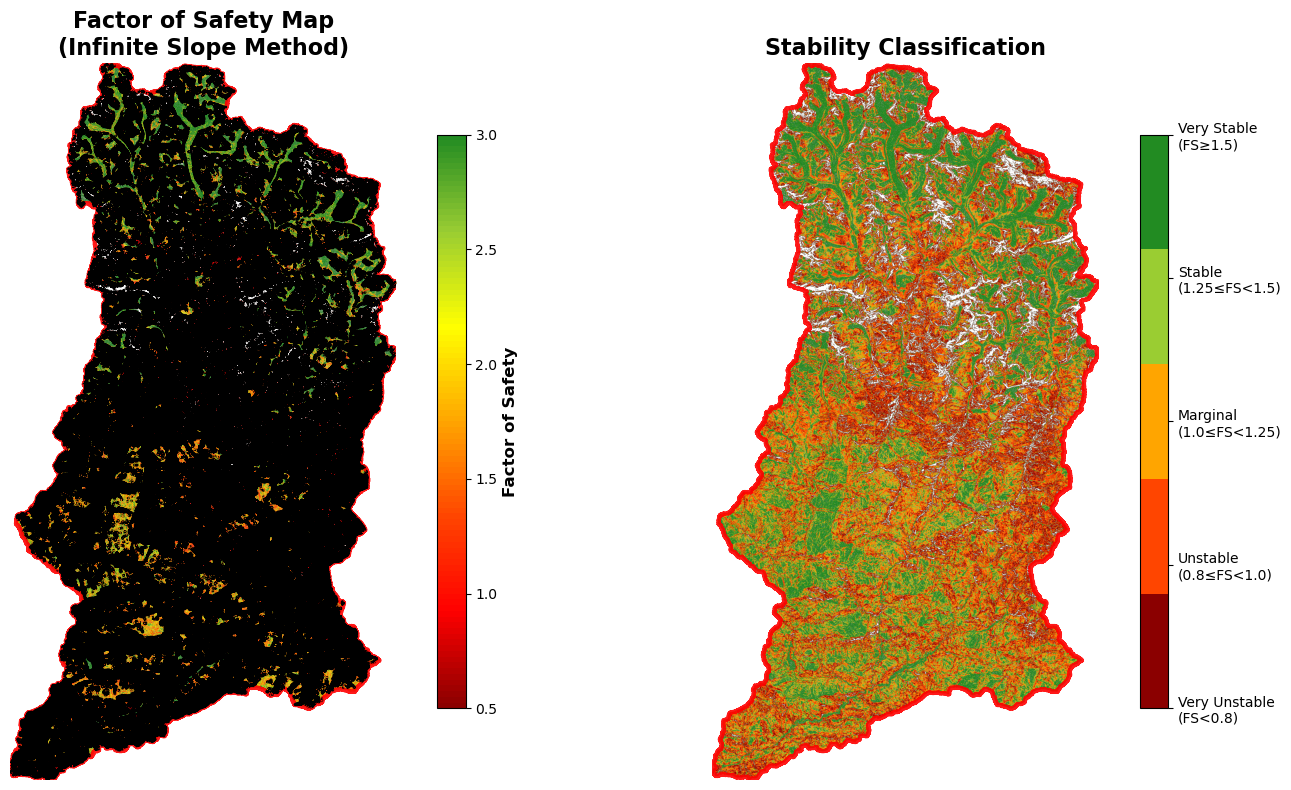

Step 6 enhanced Factor of Safety analysis completed successfully!
Step 6 enhanced results saved!


In [4]:
# STEP 6: ENHANCED FACTOR OF SAFETY ANALYSIS WITH EXACT INFINITE SLOPE METHOD

import os
import numpy as np
import rasterio
from rasterio.mask import mask
import geopandas as gpd
from scipy.ndimage import binary_opening, binary_closing, label
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import pickle
import warnings
warnings.filterwarnings('ignore')

def load_watershed_boundary_for_overlay(config):
    """
    Load watershed boundary from Step 1 results for overlay on visualizations
    """
    try:
        # Try to load from Step 1 results first
        step1_pickle_path = os.path.join(config.OUTPUT_DIR, 'step1_results.pkl')
        if os.path.exists(step1_pickle_path):
            with open(step1_pickle_path, 'rb') as f:
                step1_results = pickle.load(f)
            
            if 'watershed_vector' in step1_results and step1_results['watershed_vector']:
                watershed_path = step1_results['watershed_vector']
                if os.path.exists(watershed_path):
                    watershed_gdf = gpd.read_file(watershed_path)
                    print(f"Loaded watershed boundary from: {watershed_path}")
                    return watershed_gdf
        
        # Fallback: search in expected directories
        search_paths = [
            os.path.join(config.OUTPUT_DIR, 'whitebox_watershed', 'watershed.shp'),
            os.path.join(config.OUTPUT_DIR, 'step2_clipped_dem', 'target_basin_mask.shp'),
            os.path.join(config.OUTPUT_DIR, 'watershed.shp')
        ]
        
        for path in search_paths:
            if os.path.exists(path):
                watershed_gdf = gpd.read_file(path)
                print(f"Found watershed boundary at: {path}")
                return watershed_gdf
        
        print("Warning: Could not find watershed boundary for overlay")
        return None
        
    except Exception as e:
        print(f"Error loading watershed boundary: {e}")
        return None

def calculate_factor_of_safety_infinite_slope_exact(slope_deg, soil_depth, wetness, config):
    """
    Calculate Factor of Safety using exact SAGA infinite slope method
    """
    # Get soil parameters (exact SAGA values)
    cohesion = getattr(config, 'SOIL_COHESION', 9.8)  # kPa
    phi_deg = getattr(config, 'SOIL_FRICTION_ANGLE', 30.0)  # degrees
    gamma_sat = getattr(config, 'SOIL_UNIT_WEIGHT', 21.0)  # kN/m³
    gamma_w = 10.0  # EXACT SAGA value (not 9.81)
    
    print(f"Factor of Safety parameters:")
    print(f"  - Cohesion: {cohesion} kPa")
    print(f"  - Friction angle: {phi_deg}°")
    print(f"  - Soil unit weight: {gamma_sat} kN/m³")
    print(f"  - Water unit weight: {gamma_w} kN/m³")
    
    # Convert to radians
    slope_rad = np.deg2rad(slope_deg)
    phi_rad = np.deg2rad(phi_deg)
    
    # Create valid mask - only where we have valid slope, soil depth, and wetness
    valid_mask = (
        (slope_deg > 0) & (soil_depth > 0) & (wetness >= 0) &
        (np.sin(slope_rad) > 0) & np.isfinite(slope_deg) &
        np.isfinite(soil_depth) & np.isfinite(wetness)
    )
    
    # Initialize arrays with NaN
    rt = np.full(slope_deg.shape, np.nan)
    rc = np.full(slope_deg.shape, np.nan)
    rm = np.full(slope_deg.shape, np.nan)
    factor_of_safety = np.full(slope_deg.shape, np.nan)
    
    # Calculate RT (friction component) - EXACT SAGA formula
    rt_mask = valid_mask & (np.tan(slope_rad) > 0)
    rt[rt_mask] = np.tan(phi_rad) / np.tan(slope_rad[rt_mask])
    
    # Calculate RC (cohesion component) - EXACT SAGA formula
    denominator = soil_depth * gamma_sat * np.sin(slope_rad) * np.cos(slope_rad)
    rc_mask = valid_mask & (denominator > 0)
    rc[rc_mask] = cohesion / denominator[rc_mask]
    
    # Calculate RM (pore pressure component) - EXACT SAGA formula with gamma_w = 10
    rm[valid_mask] = rt[valid_mask] * wetness[valid_mask] * gamma_w / gamma_sat
    
    # Calculate Factor of Safety: FS = RT + RC - RM (EXACT SAGA formula)
    factor_of_safety[valid_mask] = rt[valid_mask] + rc[valid_mask] - rm[valid_mask]
    
    # Apply SAGA's limits
    factor_of_safety = np.clip(factor_of_safety, 0.0, 10.0)
    
    return factor_of_safety, rt, rc, rm, valid_mask

def create_stability_classification_exact(factor_of_safety, valid_mask):
    """
    Create stability classes using exact SAGA classification
    """
    stability_class = np.zeros(factor_of_safety.shape, dtype=np.int16)
    
    # SAGA's exact stability classification
    stability_class[valid_mask] = np.select(
        [
            factor_of_safety[valid_mask] < 0.8,   # Very Unstable
            (factor_of_safety[valid_mask] >= 0.8) & (factor_of_safety[valid_mask] < 1.0),   # Unstable
            (factor_of_safety[valid_mask] >= 1.0) & (factor_of_safety[valid_mask] < 1.25),  # Marginally Stable
            (factor_of_safety[valid_mask] >= 1.25) & (factor_of_safety[valid_mask] < 1.5),  # Stable
            factor_of_safety[valid_mask] >= 1.5    # Very Stable
        ],
        [1, 2, 3, 4, 5],
        default=0
    )
    
    return stability_class

def identify_critical_areas_exact(factor_of_safety, valid_mask, pixel_size):
    """
    Identify critical zones using exact SAGA approach
    """
    # Critical areas: FS < 1.2 (SAGA threshold)
    critical_mask = (factor_of_safety < 1.2) & valid_mask
    
    # Apply morphological operations to clean up small isolated areas
    critical_cleaned = binary_opening(critical_mask, structure=np.ones((3,3)))
    critical_cleaned = binary_closing(critical_cleaned, structure=np.ones((5,5)))
    
    # Label connected components
    labeled_critical, num_features = label(critical_cleaned)
    
    critical_zones = []
    pixel_area = pixel_size * pixel_size  # m²
    
    for i in range(1, num_features + 1):
        zone_mask = labeled_critical == i
        zone_size_pixels = np.sum(zone_mask)
        zone_area_m2 = zone_size_pixels * pixel_area
        
        # Only consider zones larger than 25 pixels (SAGA minimum)
        if zone_size_pixels > 25:
            zone_fos = factor_of_safety[zone_mask]
            critical_zones.append({
                'id': i,
                'size_pixels': zone_size_pixels,
                'area_m2': zone_area_m2,
                'mean_fos': np.nanmean(zone_fos),
                'min_fos': np.nanmin(zone_fos)
            })
    
    return labeled_critical, critical_zones

def calculate_stability_statistics_exact(factor_of_safety, valid_mask):
    """
    Calculate comprehensive stability statistics
    """
    fs_valid = factor_of_safety[valid_mask]
    
    if len(fs_valid) == 0:
        return {}
    
    return {
        'mean': float(np.mean(fs_valid)),
        'median': float(np.median(fs_valid)),
        'std': float(np.std(fs_valid)),
        'min': float(np.min(fs_valid)),
        'max': float(np.max(fs_valid)),
        'very_unstable_pct': float(np.sum(fs_valid < 0.8) / len(fs_valid) * 100),
        'unstable_pct': float(np.sum((fs_valid >= 0.8) & (fs_valid < 1.0)) / len(fs_valid) * 100),
        'marginally_stable_pct': float(np.sum((fs_valid >= 1.0) & (fs_valid < 1.25)) / len(fs_valid) * 100),
        'stable_pct': float(np.sum((fs_valid >= 1.25) & (fs_valid < 1.5)) / len(fs_valid) * 100),
        'very_stable_pct': float(np.sum(fs_valid >= 1.5) / len(fs_valid) * 100),
        'total_pixels': len(fs_valid)
    }

def apply_watershed_mask_to_fos(factor_of_safety, step2_results):
    """
    Apply watershed mask to Factor of Safety results
    """
    try:
        import geopandas as gpd
        from rasterio.features import rasterize
        
        # Load the target basin mask
        basin_mask_gdf = gpd.read_file(step2_results['target_basin_mask'])
        
        # Get raster properties
        with rasterio.open(step2_results['target_basin_dem']) as src:
            transform = src.transform
            width = src.width
            height = src.height
        
        # Rasterize the watershed polygon
        watershed_mask = rasterize(
            [geom for geom in basin_mask_gdf.geometry],
            out_shape=(height, width),
            transform=transform,
            fill=0,
            default_value=1,
            dtype=np.uint8
        )
        
        # Apply mask - set areas outside watershed to NaN
        factor_of_safety_masked = np.where(watershed_mask == 1, factor_of_safety, np.nan)
        
        print(f"Watershed mask applied to Factor of Safety")
        return factor_of_safety_masked
        
    except Exception as e:
        print(f"Could not apply watershed mask: {e}")
        return factor_of_safety

def add_watershed_boundary_to_plot(ax, watershed_gdf, raster_profile):
    """
    Add watershed boundary overlay to a plot axis with proper coordinate handling
    """
    try:
        if watershed_gdf is not None:
            # Ensure CRS compatibility
            raster_crs = raster_profile.get('crs', None)
            if raster_crs and watershed_gdf.crs != raster_crs:
                watershed_gdf = watershed_gdf.to_crs(raster_crs)
            
            # Get raster transform and bounds for proper plotting
            transform = raster_profile.get('transform', None)
            if transform:
                # Convert geometries to pixel coordinates
                from rasterio.features import geometry_mask
                from shapely.ops import transform as shapely_transform
                
                # Create inverse transform function
                def pixel_transform(x, y):
                    col, row = ~transform * (x, y)
                    return col, row
                
                # Transform watershed boundary to pixel coordinates
                watershed_pixel = watershed_gdf.geometry.apply(
                    lambda geom: shapely_transform(pixel_transform, geom)
                )
                
                # Plot the transformed boundary
                for geom in watershed_pixel:
                    if geom.geom_type == 'Polygon':
                        x, y = geom.exterior.xy
                        ax.plot(x, y, color='red', linewidth=3, alpha=0.9, label='Watershed Boundary')
                    elif geom.geom_type == 'MultiPolygon':
                        for poly in geom.geoms:
                            x, y = poly.exterior.xy
                            ax.plot(x, y, color='red', linewidth=3, alpha=0.9, label='Watershed Boundary')
                
                return True
            else:
                # Fallback: try direct plotting (may not align perfectly)
                watershed_gdf.boundary.plot(ax=ax, color='red', linewidth=3, 
                                          label='Watershed Boundary', alpha=0.9)
                return True
                
    except Exception as e:
        print(f"Could not add watershed boundary: {e}")
        print(f"Watershed CRS: {watershed_gdf.crs if watershed_gdf is not None else 'None'}")
        print(f"Raster CRS: {raster_profile.get('crs', 'None')}")
        return False
    return False

def create_comprehensive_fos_visualization(factor_of_safety, stability_class, rt, rc, rm, 
                                         slope_deg, soil_depth, wetness, valid_mask, 
                                         stats, critical_zones, config, output_dir, 
                                         raster_profile):
    """
    Create simplified Factor of Safety visualization with only FoS map and classification
    """
    # Load watershed boundary for overlay
    watershed_gdf = load_watershed_boundary_for_overlay(config)
    
    # Create simplified visualization - only 2 maps
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    
    # Custom colormaps
    fs_colors = ['#8b0000', '#ff0000', '#ff4500', '#ffa500', '#ffff00', '#9acd32', '#228b22']
    fs_cmap = LinearSegmentedColormap.from_list('fos', fs_colors, N=100)
    fs_cmap.set_bad(alpha=0)
    
    stability_colors = ['#8b0000', '#ff4500', '#ffa500', '#9acd32', '#228b22']
    stability_cmap = ListedColormap(stability_colors)
    stability_cmap.set_bad(alpha=0)
    
    # Prepare visualization data with proper masking
    fs_viz = np.where(valid_mask, factor_of_safety, np.nan)
    stability_viz = np.where(valid_mask & (stability_class > 0), stability_class, np.nan)
    
    # 1. Factor of Safety Map
    im1 = ax1.imshow(fs_viz, cmap=fs_cmap, vmin=0.5, vmax=3.0, aspect='equal')
    ax1.set_title('Factor of Safety Map\n(Infinite Slope Method)', fontsize=16, fontweight='bold')
    ax1.axis('off')
    
    # Add watershed boundary to main FoS map
    boundary_added = add_watershed_boundary_to_plot(ax1, watershed_gdf, raster_profile)
    
    # Add FS = 1.0 contour line
    try:
        contour = ax1.contour(fs_viz, levels=[1.0], colors=['black'], linewidths=2)
        ax1.clabel(contour, inline=True, fontsize=10, fmt='FS=%.1f')
    except:
        pass
    
    cbar1 = plt.colorbar(im1, ax=ax1, shrink=0.8)
    cbar1.set_label('Factor of Safety', fontsize=12, fontweight='bold')
    
    # 2. Stability Classification
    im2 = ax2.imshow(stability_viz, cmap=stability_cmap, vmin=1, vmax=5, aspect='equal')
    ax2.set_title('Stability Classification', fontsize=16, fontweight='bold')
    ax2.axis('off')
    
    # Add watershed boundary to stability map
    add_watershed_boundary_to_plot(ax2, watershed_gdf, raster_profile)
    
    cbar2 = plt.colorbar(im2, ax=ax2, shrink=0.8, ticks=[1,2,3,4,5])
    cbar2.set_ticklabels(['Very Unstable\n(FS<0.8)', 'Unstable\n(0.8≤FS<1.0)', 
                         'Marginal\n(1.0≤FS<1.25)', 'Stable\n(1.25≤FS<1.5)', 
                         'Very Stable\n(FS≥1.5)'])
    
    plt.tight_layout()
    
    # Save visualization
    viz_path = os.path.join(output_dir, 'factor_of_safety_analysis_enhanced.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def step6_factor_of_safety_enhanced(config, step3_results, step4_results, step5_results):
    """
    Enhanced Step 6: Factor of Safety analysis using exact SAGA infinite slope method
    """
    print("Starting enhanced Factor of Safety analysis")
    
    output_dir = os.path.join(config.OUTPUT_DIR, 'step6_factor_of_safety_enhanced')
    os.makedirs(output_dir, exist_ok=True)
    
    # Load Step 2 results for watershed masking
    step2_pickle_path = os.path.join(config.OUTPUT_DIR, 'step2_results.pkl')
    if os.path.exists(step2_pickle_path):
        with open(step2_pickle_path, 'rb') as f:
            step2_results = pickle.load(f)
    else:
        step2_results = None
        print("Warning: Step 2 results not found - cannot apply watershed mask")
    
    # Load input rasters
    with rasterio.open(step3_results['slope_angle_map']) as src:
        slope_deg = src.read(1)
        profile = src.profile.copy()
        pixel_size = src.res[0]  # Assuming square pixels
    
    with rasterio.open(step4_results['soil_thickness']) as src:
        soil_depth = src.read(1)
    
    with rasterio.open(step5_results['total_wetness']) as src:
        wetness = src.read(1)
    
    # Align raster dimensions
    min_rows = min(slope_deg.shape[0], soil_depth.shape[0], wetness.shape[0])
    min_cols = min(slope_deg.shape[1], soil_depth.shape[1], wetness.shape[1])
    
    slope_deg = slope_deg[:min_rows, :min_cols]
    soil_depth = soil_depth[:min_rows, :min_cols]
    wetness = wetness[:min_rows, :min_cols]
    
    # Handle NoData - keep NaN for proper masking
    print("Calculating Factor of Safety using exact infinite slope method")
    
    # Calculate Factor of Safety using exact SAGA method
    factor_of_safety, rt, rc, rm, valid_mask = calculate_factor_of_safety_infinite_slope_exact(
        slope_deg, soil_depth, wetness, config)
    
    # Apply watershed mask if available
    if step2_results:
        factor_of_safety = apply_watershed_mask_to_fos(factor_of_safety, step2_results)
        # Update valid mask after watershed masking
        valid_mask = valid_mask & np.isfinite(factor_of_safety)
    
    # Create stability classification
    stability_class = create_stability_classification_exact(factor_of_safety, valid_mask)
    
    # Identify critical areas
    labeled_critical, critical_zones = identify_critical_areas_exact(
        factor_of_safety, valid_mask, pixel_size)
    
    # Calculate statistics
    stats = calculate_stability_statistics_exact(factor_of_safety, valid_mask)
    
    print("Creating comprehensive visualization with watershed boundary overlay")
    
    # Create visualization with watershed boundary
    viz_path = create_comprehensive_fos_visualization(
        factor_of_safety, stability_class, rt, rc, rm,
        slope_deg, soil_depth, wetness, valid_mask,
        stats, critical_zones, config, output_dir, profile
    )
    
    # Save output rasters
    profile.update({
        'height': min_rows,
        'width': min_cols,
        'dtype': rasterio.float64,
        'nodata': np.nan,
        'compress': 'lzw'
    })
    
    # Save Factor of Safety
    fos_path = os.path.join(output_dir, "factor_of_safety_enhanced.tif")
    with rasterio.open(fos_path, 'w', **profile) as dst:
        dst.write(factor_of_safety.astype(np.float64), 1)
    
    # Save stability classification
    stability_path = os.path.join(output_dir, "stability_classification_enhanced.tif")
    profile_int = profile.copy()
    profile_int.update({'dtype': rasterio.int16, 'nodata': 0})
    
    with rasterio.open(stability_path, 'w', **profile_int) as dst:
        dst.write(stability_class.astype(np.int16), 1)
    
    # Save critical zones if any
    critical_path = None
    if len(critical_zones) > 0:
        critical_path = os.path.join(output_dir, "critical_zones_enhanced.tif")
        with rasterio.open(critical_path, 'w', **profile_int) as dst:
            dst.write(labeled_critical.astype(np.int16), 1)
    
    print("Step 6 enhanced Factor of Safety analysis completed successfully!")
    
    return {
        'factor_of_safety_map': fos_path,
        'stability_classification': stability_path,
        'critical_zones_map': critical_path,
        'visualization': viz_path,
        'statistics': stats,
        'critical_zones': critical_zones,
        'parameters': {
            'cohesion': getattr(config, 'SOIL_COHESION', 9.8),
            'friction_angle': getattr(config, 'SOIL_FRICTION_ANGLE', 30.0),
            'unit_weight': getattr(config, 'SOIL_UNIT_WEIGHT', 21.0),
            'water_weight': 10.0  # EXACT SAGA value
        },
        'method': 'infinite_slope_exact_SAGA',
        'algorithms_used': {
            'slope': step3_results['algorithms_used']['slope'],
            'soil_thickness': step4_results['method'], 
            'wetness': step5_results['algorithms_used']
        }
    }

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"
        # Factor of Safety parameters (exact SAGA values)
        self.SOIL_COHESION = 9.8  # kPa
        self.SOIL_FRICTION_ANGLE = 30.0  # degrees
        self.SOIL_UNIT_WEIGHT = 21.0  # kN/m³

# Main execution
if __name__ == "__main__":
    config = Config()
    
    # Load previous enhanced results
    step3_pickle_path = os.path.join(config.OUTPUT_DIR, 'step3_results_enhanced.pkl')
    step4_pickle_path = os.path.join(config.OUTPUT_DIR, 'step4_results.pkl')
    step5_pickle_path = os.path.join(config.OUTPUT_DIR, 'step5_results_enhanced.pkl')
    
    required_files = [step3_pickle_path, step4_pickle_path, step5_pickle_path]
    missing_files = [f for f in required_files if not os.path.exists(f)]
    
    if not missing_files:
        with open(step3_pickle_path, 'rb') as f:
            step3_results = pickle.load(f)
        
        with open(step4_pickle_path, 'rb') as f:
            step4_results = pickle.load(f)
        
        with open(step5_pickle_path, 'rb') as f:
            step5_results = pickle.load(f)
        
        try:
            step6_results = step6_factor_of_safety_enhanced(
                config, step3_results, step4_results, step5_results)
            
            # Save results
            step6_pickle_path = os.path.join(config.OUTPUT_DIR, 'step6_results_enhanced.pkl')
            with open(step6_pickle_path, 'wb') as f:
                pickle.dump(step6_results, f)
            
            print("Step 6 enhanced results saved!")
                
        except Exception as e:
            print(f"Step 6 enhanced failed: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Missing required files: {missing_files}")
        print("Please ensure Steps 3, 4, and 5 enhanced are completed first.")

Starting enhanced mathematical model validation
Processing enhanced validation data
Creating enhanced validation visualization


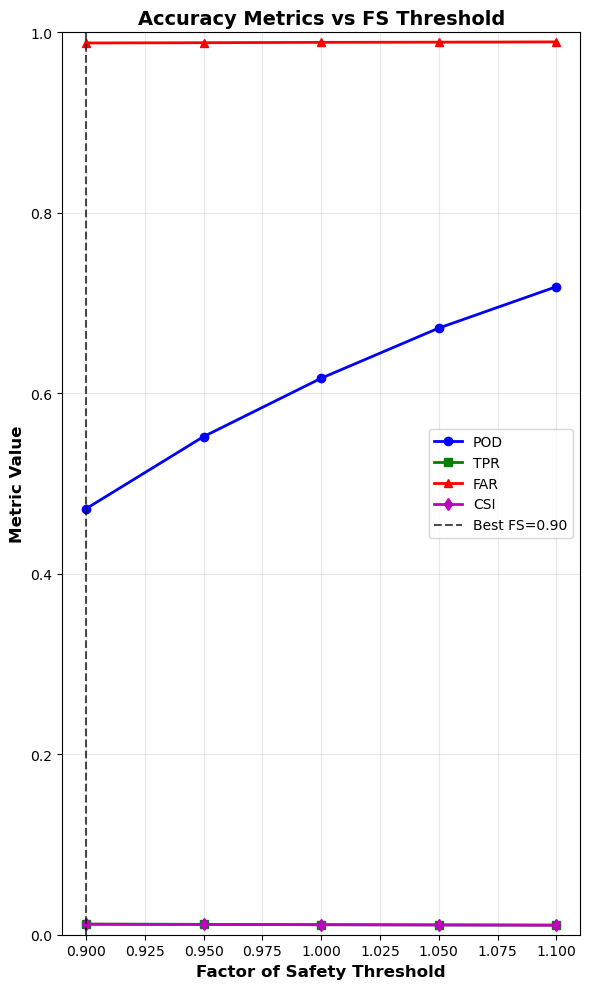

Enhanced Step 7 results saved!


In [1]:
'F1_Score'
    }
    
    # Best Matthews Correlation Coefficient
    best_mcc = max(base_results, key=lambda x: x['mcc'])
    optimization_results['best_mcc'] = {
        'threshold': best_mcc['fs_threshold'],
        'value': best_mcc['mcc'],
        'criterion': 'MCC'
    }
    
    # Best Balanced Accuracy
    best_balanced = max(base_results, key=lambda x: x['balanced_accuracy'])
    optimization_results['best_balanced'] = {
        'threshold': best_balanced['fs_threshold'],
        'value': best_balanced['balanced_accuracy'],
        'criterion': 'Balanced_Accuracy'
    }
    
    # Ensemble optimal threshold (average of top criteria)
    ensemble_threshold = np.mean([
        optimization_results['best_csi']['threshold'],
        optimization_results['best_f1']['threshold'],
        optimization_results['best_mcc']['threshold']
    ])
    
    optimization_results['ensemble'] = {
        'threshold': ensemble_threshold,
        'criterion': 'Ensemble_Average'
    }
    
    # Return best CSI as primary (maintains compatibility)
    return optimization_results['best_csi']['threshold'], optimization_results

def create_validation_visualization(fs_data, observed_raster, validation_results, 
                                  best_threshold, landslides_count, output_dir):
    # Create portrait graph visualization
    fig, ax = plt.subplots(1, 1, figsize=(6, 10))  # Changed from (10, 6) to (6, 10) for portrait
    
    # Accuracy metrics vs FS threshold
    base_results = [r for r in validation_results if r['buffer_distance'] == 0]
    if base_results:
        df_base = pd.DataFrame(base_results)
        ax.plot(df_base['fs_threshold'], df_base['POD'], 'b-o', label='POD', linewidth=2)
        ax.plot(df_base['fs_threshold'], df_base['TPR'], 'g-s', label='TPR', linewidth=2)
        ax.plot(df_base['fs_threshold'], df_base['FAR'], 'r-^', label='FAR', linewidth=2)
        ax.plot(df_base['fs_threshold'], df_base['CSI'], 'm-d', label='CSI', linewidth=2)
        
        ax.axvline(x=best_threshold, color='black', linestyle='--', alpha=0.7, 
                   label=f'Best FS={best_threshold:.2f}')
        
        ax.set_xlabel('Factor of Safety Threshold', fontsize=12, fontweight='bold')
        ax.set_ylabel('Metric Value', fontsize=12, fontweight='bold')
        ax.set_title('Accuracy Metrics vs FS Threshold', fontsize=14, fontweight='bold')
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    plt.tight_layout()
    
    viz_path = os.path.join(output_dir, 'model_validation_results.png')
    plt.savefig(viz_path, dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    
    return viz_path

def step7_model_validation_enhanced(config, step6_results, landslide_inventory_path):
    print("Starting enhanced mathematical model validation")
    
    output_dir = os.path.join(config.OUTPUT_DIR, 'step7_model_validation_enhanced')
    os.makedirs(output_dir, exist_ok=True)
    
    # Check if landslide inventory exists
    if not landslide_inventory_path or not os.path.exists(landslide_inventory_path):
        print("No landslide inventory found - skipping validation")
        return create_no_validation_result(output_dir)
    
    # Load landslide inventory
    landslides = gpd.read_file(landslide_inventory_path)
    
    # Load factor of safety map
    with rasterio.open(step6_results['factor_of_safety_map']) as src:
        fs_data = src.read(1)
        transform = src.transform
        crs = src.crs
        bounds = src.bounds
    
    # Reproject landslides if needed
    if landslides.crs != crs:
        landslides = landslides.to_crs(crs)
    
    # Clip landslides to study area
    landslides_clipped = clip_landslides_to_study_area(landslides, bounds)
    
    if len(landslides_clipped) == 0:
        print("No landslides found in study area")
        return create_no_validation_result(output_dir)
    
    print("Processing enhanced validation data")
    
    # Enhanced incremental buffers
    num_rings = getattr(config, 'VALIDATION_NUM_RINGS', 3)
    buffer_width = getattr(config, 'VALIDATION_BUFFER_WIDTH', 10.0)
    
    buffer_layers = create_incremental_buffers_enhanced(landslides_clipped, num_rings, buffer_width)
    
    # Enhanced observed raster
    observed_raster = create_observed_raster_enhanced(buffer_layers, fs_data.shape, transform)
    
    # Enhanced validation metrics calculation
    fs_thresholds = [lim/100.0 for lim in range(90, 115, 5)]  # 0.90 to 1.10
    
    validation_results = calculate_validation_metrics_enhanced(
        fs_data, observed_raster, fs_thresholds, num_rings, buffer_width)
    
    # Enhanced threshold optimization
    best_threshold, optimization_results = find_optimal_threshold_enhanced(validation_results)
    best_metrics = next((r for r in validation_results 
                        if abs(r['fs_threshold'] - best_threshold) < 0.01 
                        and r['buffer_distance'] == 0), None)
    
    # Statistical significance analysis
    statistical_analysis = calculate_statistical_significance(validation_results, 'CSI')
    
    print("Creating enhanced validation visualization")
    
    # Create visualization
    viz_path = create_validation_visualization(
        fs_data, observed_raster, validation_results, best_threshold, 
        len(landslides_clipped), output_dir)
    
    # Save enhanced results
    metrics_df = pd.DataFrame(validation_results)
    metrics_path = os.path.join(output_dir, "enhanced_validation_metrics.csv")
    metrics_df.to_csv(metrics_path, index=False)
    
    # Save optimization results
    optimization_df = pd.DataFrame([
        {
            'criterion': opt_data['criterion'],
            'optimal_threshold': opt_data['threshold'],
            'optimal_value': opt_data.get('value', np.nan)
        }
        for opt_data in optimization_results.values()
    ])
    optimization_path = os.path.join(output_dir, "threshold_optimization.csv")
    optimization_df.to_csv(optimization_path, index=False)
    
    # Save observed raster
    observed_path = os.path.join(output_dir, "observed_landslides_enhanced.tif")
    profile = {
        'driver': 'GTiff', 'dtype': rasterio.int16, 'nodata': 0,
        'width': fs_data.shape[1], 'height': fs_data.shape[0], 'count': 1,
        'crs': crs, 'transform': transform, 'compress': 'lzw'
    }
    
    with rasterio.open(observed_path, 'w', **profile) as dst:
        dst.write(observed_raster, 1)
    
    return {
        'validation_performed': True,
        'landslide_count': len(landslides_clipped),
        'best_threshold': best_threshold,
        'best_metrics': best_metrics,
        'optimization_results': optimization_results,
        'statistical_analysis': statistical_analysis,
        'fs_thresholds': fs_thresholds,
        'num_rings': num_rings,
        'buffer_width': buffer_width,
        'enhanced_metrics_csv': metrics_path,
        'optimization_csv': optimization_path,
        'observed_raster': observed_path,
        'visualization': viz_path,
        'validation_summary': {
            'csi': best_metrics['CSI'] if best_metrics else 0,
            'f1_score': best_metrics['f1_score'] if best_metrics else 0,
            'mcc': best_metrics['mcc'] if best_metrics else 0,
            'balanced_accuracy': best_metrics['balanced_accuracy'] if best_metrics else 0,
            'pod': best_metrics['POD'] if best_metrics else 0,
            'far': best_metrics['FAR'] if best_metrics else 0,
            'performance': 'EXCELLENT' if best_metrics and best_metrics['CSI'] >= 0.5 else
                          'GOOD' if best_metrics and best_metrics['CSI'] >= 0.3 else
                          'MODERATE' if best_metrics and best_metrics['CSI'] >= 0.1 else 'POOR'
        }
    }

def create_no_validation_result(output_dir):
    # Create result when no validation can be performed
    no_validation_file = os.path.join(output_dir, 'no_validation_performed.txt')
    with open(no_validation_file, 'w') as f:
        f.write("ENHANCED MODEL VALIDATION - NO LANDSLIDE INVENTORY\n")
        f.write("="*50 + "\n\n")
        f.write("No landslide inventory data available.\n")
        f.write("Enhanced model validation could not be performed.\n")
    
    return {
        'validation_performed': False,
        'reason': 'No landslide inventory available',
        'note_file': no_validation_file,
        'landslide_count': 0,
        'best_threshold': 1.0,
        'validation_summary': {
            'performance': 'NOT_VALIDATED'
        }
    }

class Config:
    def __init__(self):
        self.DEM_PATH = "Orig_Dem/Orig_Dem.tif"
        self.OUTPUT_DIR = "FoS_Analysis"
        # Enhanced validation parameters
        self.VALIDATION_NUM_RINGS = 3
        self.VALIDATION_BUFFER_WIDTH = 10.0

# Main execution
if __name__ == "__main__":
    config = Config()
    
    # Load Step 6 results
    step6_pickle_path = os.path.join(config.OUTPUT_DIR, 'step6_results_enhanced.pkl')
    
    if os.path.exists(step6_pickle_path):
        with open(step6_pickle_path, 'rb') as f:
            step6_results = pickle.load(f)
        
        # Set landslide inventory path
        landslide_inventory_path = "Inventory/Invent_Study_area_Khubu_CA.shp"
        
        try:
            step7_results = step7_model_validation_enhanced(
                config, step6_results, landslide_inventory_path)
            
            # Save results
            step7_pickle_path = os.path.join(config.OUTPUT_DIR, 'step7_results_enhanced.pkl')
            with open(step7_pickle_path, 'wb') as f:
                pickle.dump(step7_results, f)
            
            print("Enhanced Step 7 results saved!")
                
        except Exception as e:
            print(f"Enhanced Step 7 failed: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"Step 6 results not found: {step6_pickle_path}")
        print("Please ensure Step 6 enhanced is completed first.")